In [50]:
# *****************************************************************************
#
#
# Purpose: Calibration of the Sick-Sicker 4-state Markov Model using 
#          Nelder-Mead Optimization
#
# Authors: 
# This work is developed by the Decision Analysis in R for Technologies in Health 
# (DARTH) workgroup:
#
# - Fernando Alarid-Escudero, PhD
# - Eva A. Enns, MS, PhD 
# - M.G. Myriam Hunink, MD, PhD 
# - Hawre J. Jalal, MD, PhD 
# - Eline Krijkamp, PhD 
# - Petros Pechlivanoglou, PhD
# - Alan Yang, MSc
#
# *****************************************************************************
#
# Notes:
#
# Please acknowledge our work. See details to cite below:
#
# - Alarid-Escudero F, MacLehose RF, Peralta Y, Kuntz KM, Enns EA. 
#   Non-identifiability in model calibration and implications for 
#   medical decision making. Med Decis Making. 2018; 38(7):810-821.
#
# - Jalal H, Pechlivanoglou P, Krijkamp E, Alarid-Escudero F, Enns E, 
#   Hunink MG. An Overview of R in Health Decision Sciences. 
#   Med Decis Making. 2017; 37(3): 735-746.
#
# *****************************************************************************

# ******************************************************************************
# 01 Calibration Overview ------------------------------------------------------
# ******************************************************************************

### 01.01 Model description  ---------------------------------------------------
# Model: Sick-Sicker 4-state Markov Model
# Inputs to be calibrated: p_S1S2, hr_S1, hr_S2
# Targets: Surv, Prev, PropSick

### 01.02 Calibration method  --------------------------------------------------
# Search method: Nelder-Mead algorithm
# Goodness-of-fit measure: Sum of Log-Likelihood

# ******************************************************************************
# 02 Setup ---------------------------------------------------------------------
# ******************************************************************************

### 02.01 Clear environment  ---------------------------------------------------
rm(list = ls())

In [51]:
### 02.02 Load packages  -------------------------------------------------------
# Install pacman if not present
if (!requireNamespace("pacman", quietly = TRUE)) install.packages("pacman")

In [52]:
# Load pacman
library(pacman)

# Load (install if needed) CRAN packages
p_load(
  lhs,          # Latin Hypercube Sampling
  plotrix,      # Plotting with confidence intervals
  psych,        # Pairs panels
  scatterplot3d,# 3D scatter plots
  ggplot2,      # Advanced plotting
  GGally,       # Pairwise plots
  mvtnorm,      # Multivariate normal distribution
  matrixcalc,   # To evaluate if matrix is positive definite
  Matrix,       # To compute nearest positive definite matrix
  DEoptim       # To optiom with genetic algorithm logic
)

In [53]:
### 03.01 Load target data  ----------------------------------------------------
load("../../data/SickSicker_CalibTargets.RData")
lst_targets <- SickSicker_targets

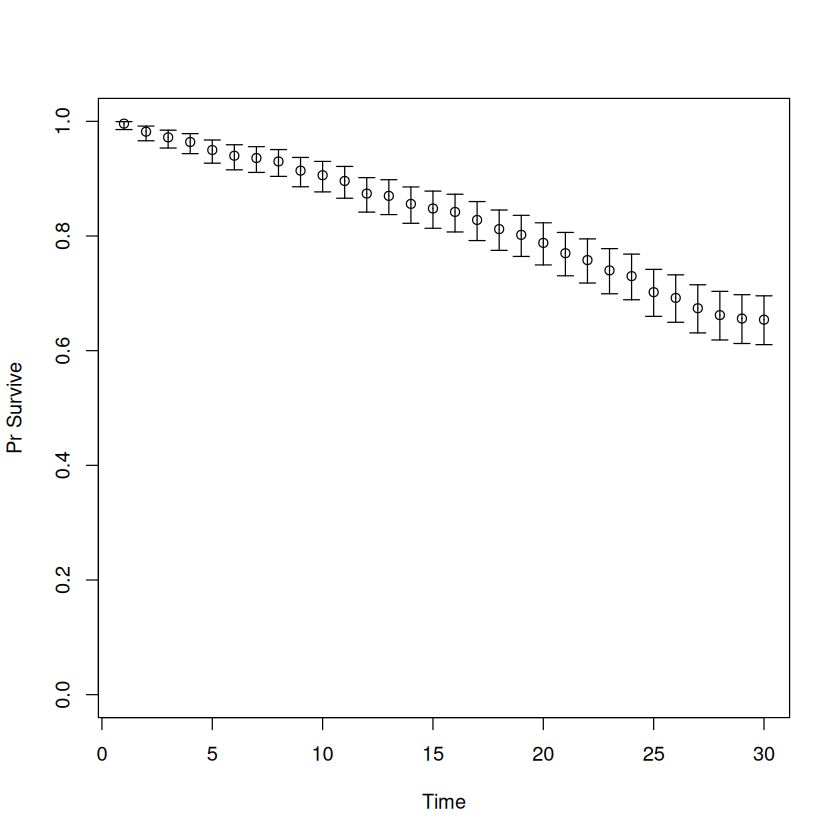

In [54]:
### 03.02 Visualize calibration targets  ---------------------------------------
# Survival ("Surv")
plotrix::plotCI(x = lst_targets$Surv$time, 
                y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", 
                ylab = "Pr Survive")

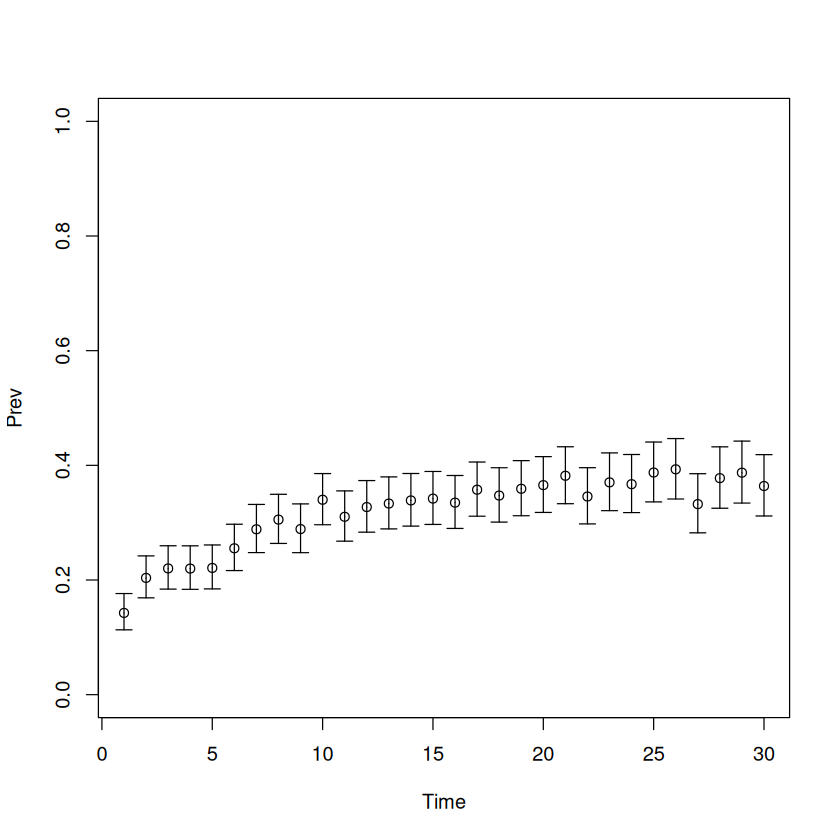

In [55]:
# Prevalence ("Prev")
plotrix::plotCI(x = lst_targets$Prev$time, 
                y = lst_targets$Prev$value,
                ui = lst_targets$Prev$ub,
                li = lst_targets$Prev$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "Prev")

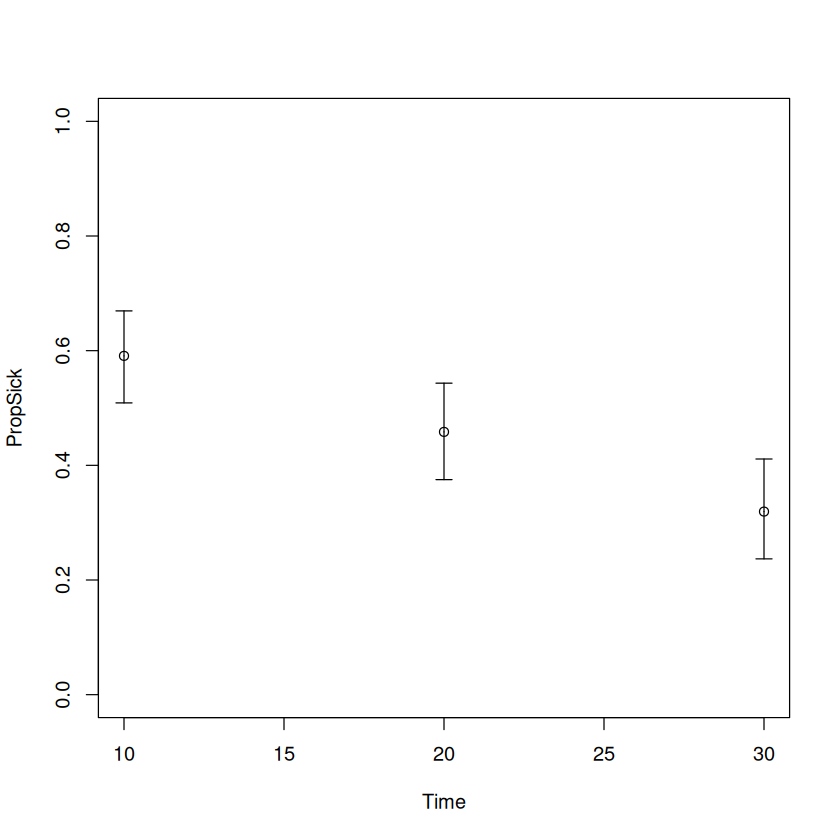

In [56]:
# Proportion who are Sick ("PropSick"), among all those afflicted (Sick+Sicker)
plotrix::plotCI(x = lst_targets$PropSick$time, 
                y = lst_targets$PropSick$value,
                ui = lst_targets$PropSick$ub,
                li = lst_targets$PropSick$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "PropSick")

In [57]:
# ******************************************************************************
# 04 Load model as a function --------------------------------------------------
# ******************************************************************************

### 04.01 Source model function  -----------------------------------------------
# Function inputs: parameters to be estimated through calibration
# Function outputs: model predictions corresponding to target data
source("../../code/Functions/SickSicker_MarkovModel_Function.R") # creates run_sick_sicker_markov()

### 04.02 Test model function  -------------------------------------------------
v_params_test <- c(p_S1S2 = 0.105, hr_S1 = 3, hr_S2 = 10)
run_sick_sicker_markov(v_params_test) # Test: function works correctly

$Surv
        1         2         3         4         5         6         7         8 
0.9950000 0.9885362 0.9810784 0.9728008 0.9637994 0.9541472 0.9439082 0.9331413 
        9        10        11        12        13        14        15        16 
0.9219015 0.9102402 0.8982055 0.8858421 0.8731922 0.8602948 0.8471865 0.8339014 
       17        18        19        20        21        22        23        24 
0.8204713 0.8069256 0.7932918 0.7795955 0.7658602 0.7521079 0.7383588 0.7246318 
       25        26        27        28        29        30 
0.7109441 0.6973115 0.6837488 0.6702694 0.6568856 0.6436086 

$Prev
        1         2         3         4         5         6         7         8 
0.1507538 0.2018249 0.2267624 0.2443252 0.2593508 0.2731265 0.2860289 0.2981972 
        9        10        11        12        13        14        15        16 
0.3097057 0.3206084 0.3309506 0.3407725 0.3501104 0.3589973 0.3674630 0.3755352 
       17        18        19        20        21        22        23        24 
0.3832387 0.3905968 0.3976304 0.4043591 0.4108009 0.4169723 0.4228887 0.4285642 
       25        26        27        28        29        30 
0.4340120 0.4392445 0.4442729 0.4491079 0.4537594 0.4582367 

$PropSick
       10        20        30 
0.5372139 0.3734392 0.2997246

In [58]:
# ******************************************************************************
# 05 Calibration specifications ------------------------------------------------
# ******************************************************************************

### 05.01 Set random seed  -----------------------------------------------------
set.seed(072218) # For reproducible sequence of random numbers

### 05.02 Define calibration parameters  ---------------------------------------
# Number of initial starting points
n_init <- 100

# Names and number of parameters to calibrate
v_param_names <- c("p_S1S2", "hr_S1", "hr_S2")
n_param       <- length(v_param_names)

# Search space bounds
lb <- c(p_S1S2 = 0.01, hr_S1 = 1.0, hr_S2 = 5)  # lower bound
ub <- c(p_S1S2 = 0.50, hr_S1 = 4.5, hr_S2 = 15) # upper bound

### 05.03 Define calibration targets  ------------------------------------------
v_target_names <- c("Surv", "Prev", "PropSick")
n_target       <- length(v_target_names)

In [59]:
### 06.01 Function to calculate goodness-of-fit  -------------------------------
f_gof <- function(v_params){
  
  # Run model for parameter set v_params
  model_res <- run_sick_sicker_markov(v_params)
  
  # Calculate goodness-of-fit of model outputs to targets
  v_GOF <- numeric(n_target)
  
  # TARGET 1: Survival ("Surv") - log likelihood  
  v_GOF[1] <- sum(dnorm(x = lst_targets$Surv$value,
                        mean = model_res$Surv,
                        sd = lst_targets$Surv$se,
                        log = TRUE))
  
  # TARGET 2: Prevalence ("Prev") - log likelihood
  v_GOF[2] <- sum(dnorm(x = lst_targets$Prev$value,
                        mean = model_res$Prev,
                        sd = lst_targets$Prev$se,
                        log = TRUE))
  
  # TARGET 3: Proportion Sick ("PropSick") - log likelihood
  v_GOF[3] <- sum(dnorm(x = lst_targets$PropSick$value,
                        mean = model_res$PropSick,
                        sd = lst_targets$PropSick$se,
                        log = TRUE))
  
  # OVERALL - weighted sum (can give different targets different weights)
  v_weights <- rep(1, n_target)
  GOF_overall <- sum(v_GOF[1:n_target] * v_weights)
  
  return(GOF_overall)
}

In [60]:
### 06.02 Test goodness-of-fit function  ---------------------------------------
f_gof(v_params = v_params_test)

[1] 135.7134

In [61]:
# ******************************************************************************
# 07 Run calibration using Nelder-Mead -----------------------------------------
# ******************************************************************************

### 07.02 Sample initial starting values  --------------------------------------
v_params_init <- matrix(nrow = n_init, ncol = n_param)
for (i in 1:n_param) {
  v_params_init[, i] <- runif(n_init, min = lb[i], max = ub[i])
}
colnames(v_params_init) <- v_param_names

In [62]:
# "Nelder-Mead", "Simulated Annealing", "Genetic Algorihtm"
methods = c("nm", "sann", "ga")

In [77]:
# Iter over methods and iterations
## Create structure to save results
results = list()

for(m in methods) {
    m_calib_res <- matrix(nrow = n_init, ncol = n_param + 1, 
                  dimnames = list(paste0("par_id_", 1:n_init),
                                  c(v_param_names, "Overall_fit")))

    l_fit_nm <- vector(mode = "list", length = n_init)
    names(l_fit_nm) <- paste0("par_id_", 1:n_init)
    
    results[[m]] = list(l_fit_nm, m_calib_res)
}

In [78]:
# Genetic algorithm
f_fitness <- function(params) {
    names(params) = v_param_names
    return(-f_gof(params))
}

In [79]:
j = 1
optim(v_params_init[j, ], f_gof,
                         control = list(fnscale = -1, maxit = 1000), 
                         hessian = TRUE)

,p_S1S2,hr_S1,hr_S2
p_S1S2,-136748.33734,-611.14968,28.008259
hr_S1,-611.14968,-11.52617,-4.892980
hr_S2,28.00826,-4.89298,-3.431215


In [87]:
# Record start time  ---------------------------------------------------
t_init <- Sys.time()
# El ajuste genetico es independiente a las iteraciones de los datos como los aguardamos
# Genetic algorithm is independent of our another iteration process (we only need to run one time)
fit_ga = DEoptim(f_fitness, lower=lb, upper=ub)
comp_time1 <- Sys.time() - t_init
comp_time1

Iteration: 1 bestvalit: -142.887181 bestmemit:    0.085917    2.376920    9.368041
Iteration: 2 bestvalit: -174.350459 bestmemit:    0.073175    3.970984   11.096356
Iteration: 3 bestvalit: -174.350459 bestmemit:    0.073175    3.970984   11.096356
Iteration: 4 bestvalit: -174.350459 bestmemit:    0.073175    3.970984   11.096356
Iteration: 5 bestvalit: -174.350459 bestmemit:    0.073175    3.970984   11.096356
Iteration: 6 bestvalit: -174.350459 bestmemit:    0.073175    3.970984   11.096356
Iteration: 7 bestvalit: -174.625634 bestmemit:    0.087133    3.424886   12.191158
Iteration: 8 bestvalit: -174.625634 bestmemit:    0.087133    3.424886   12.191158
Iteration: 9 bestvalit: -174.625634 bestmemit:    0.087133    3.424886   12.191158
Iteration: 10 bestvalit: -174.625634 bestmemit:    0.087133    3.424886   12.191158
Iteration: 11 bestvalit: -174.625634 bestmemit:    0.087133    3.424886   12.191158
Iteration: 12 bestvalit: -174.625634 bestmemit:    0.087133    3.424886   12.191158
I

Time difference of 3.037228 secs

In [88]:
for (j in 1:n_init) {

  # Nelder-Mead algorithm
  results[['nm']][[1]][[j]] <- optim(v_params_init[j, ], f_gof,
                         control = list(fnscale = -1, maxit = 1000), 
                         hessian = TRUE)
  results[['nm']][[2]][j,] <- c(results[['nm']][[1]][[j]]$par,
                                results[['nm']][[1]][[j]]$value)

  # Simulated annealing
  results[['sann']][[1]][[j]] <- optim(v_params_init[j,], f_gof,
                  method = c("SANN"),  # switches to using simulated annealing
                  control = list(temp = 10, tmax = 10, # algorithm tuning parameters
                      fnscale = -1, maxit = 1000),
                  hessian = T)
  results[['sann']][[2]][j,] = c(results[['sann']][[1]][[j]]$par,
                                 results[['sann']][[1]][[j]]$value)
    
  # Genetic algorithm
  results[['ga']][[2]][j,] = c(fit_ga$optim$bestmem, -1*fit_ga$optim$bestval)    
}
### 07.05 Calculate computation time  ------------------------------------------
comp_time2 <- Sys.time() - t_init
comp_time2

Time difference of 1.053841 mins

In [99]:
nm_model = 'sann'
l_fit_nm = results[[nm_model]][[1]]
m_calib_res = results[[nm_model]][[2]]

# ******************************************************************************
# 08 Explore calibration results -----------------------------------------------
# ******************************************************************************

### 08.01 Identify best-fitting parameter sets  --------------------------------
# Arrange parameter sets in order of fit
m_calib_res <- m_calib_res[order(-m_calib_res[, "Overall_fit"]), ]

# Best parameter set
v_param_best <- m_calib_res[1, -4]
v_param_best

# Obtain id for best set
id_best_set <- rownames(m_calib_res)[1]

# Examine the top 10 best-fitting sets
m_calib_res[1:10, ]

p_S1S2       hr_S1       hr_S2 
 0.07951204  3.90896269 11.10847890

,p_S1S2,hr_S1,hr_S2,Overall_fit
par_id_19,0.07951204,3.908963,11.10848,176.8524
par_id_80,0.08025586,3.858053,11.39907,176.8335
par_id_3,0.07906807,3.850943,11.39121,176.8248
par_id_87,0.07842534,4.232825,10.73760,176.8235
par_id_72,0.07758428,4.117232,10.98164,176.8097
par_id_74,0.07812514,3.990176,11.20357,176.8024
par_id_36,0.07935678,3.873296,11.50991,176.7767
par_id_55,0.08044506,3.647005,11.47147,176.7583
par_id_85,0.07791208,4.367658,10.61912,176.7490
par_id_34,0.08001119,4.100318,10.95481,176.7304


In [111]:
tail(m_calib_res, 3)

,p_S1S2,hr_S1,hr_S2,Overall_fit
par_id_21,0.07649889,3.663519,8.444291,157.1544
par_id_5,0.09114027,2.475142,10.202527,155.7940
par_id_65,0.08188035,3.264201,8.743389,153.3574


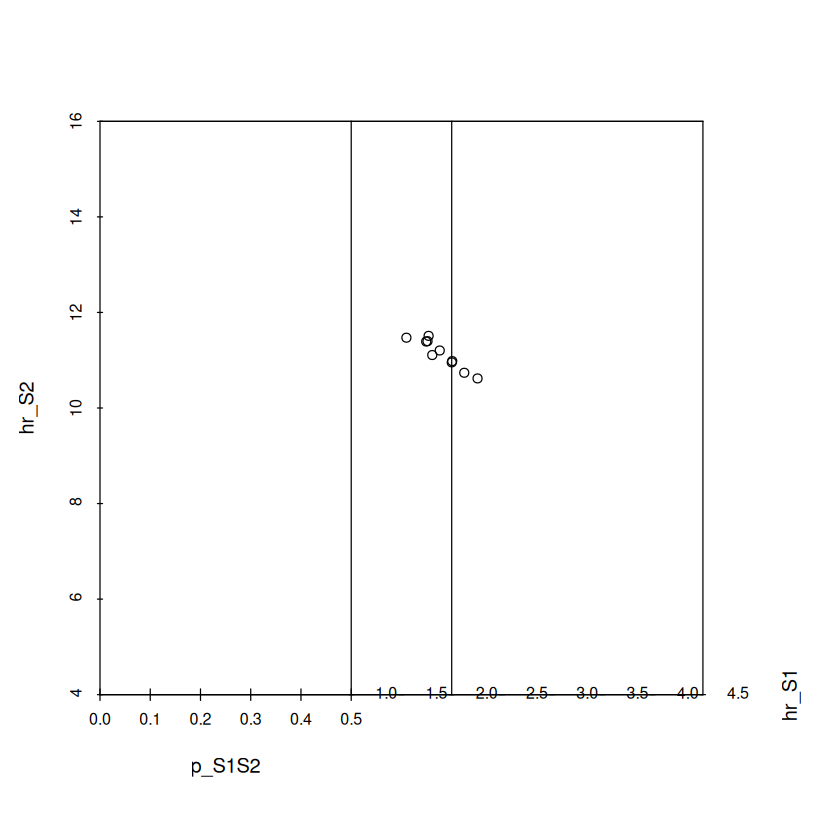

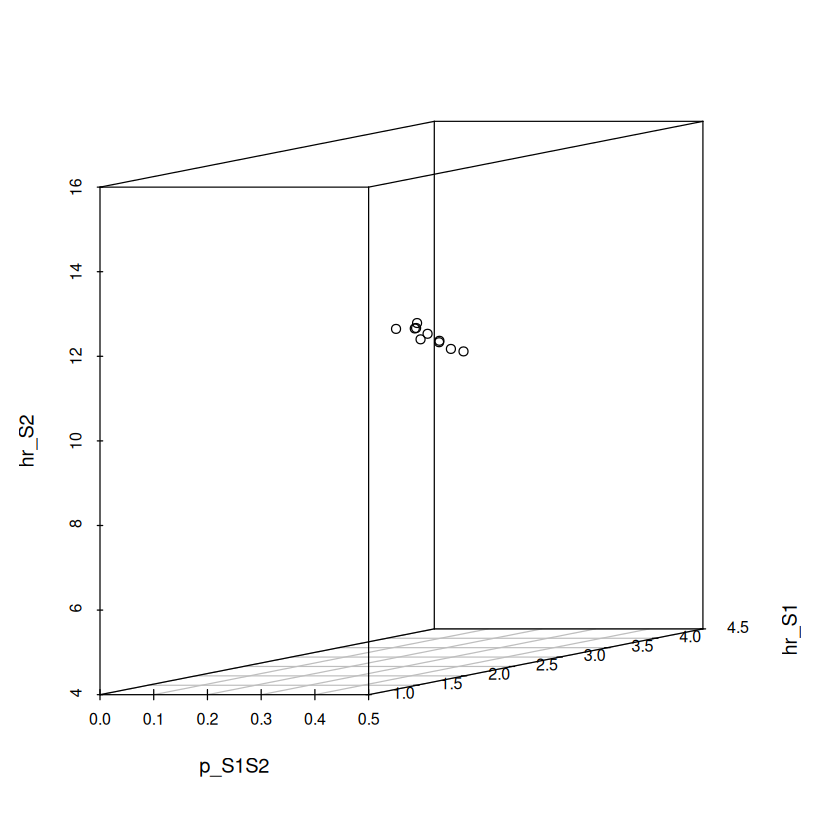

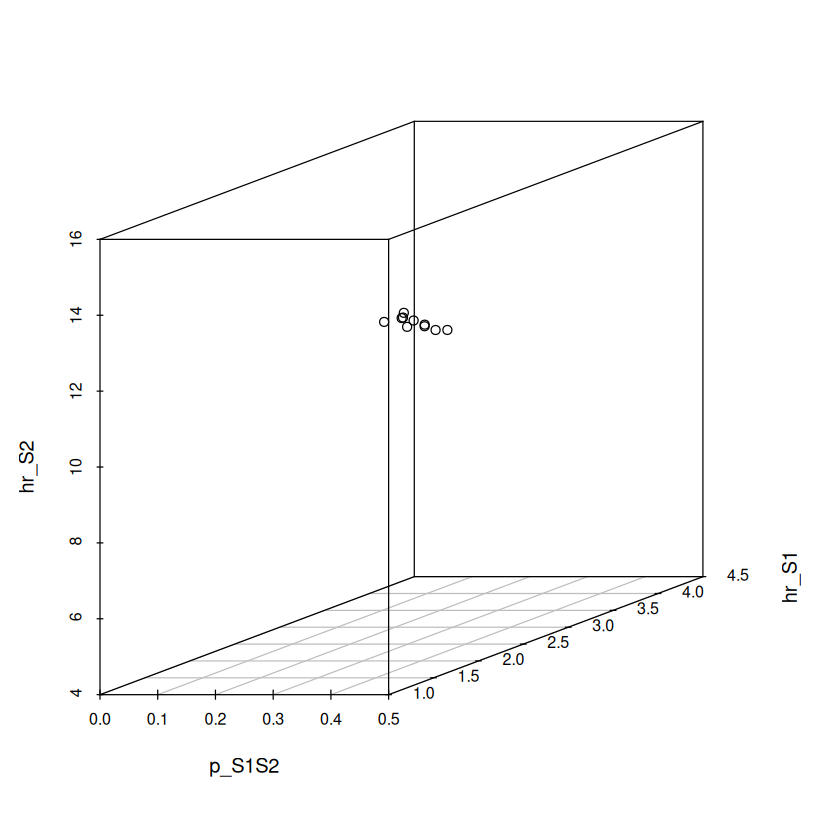

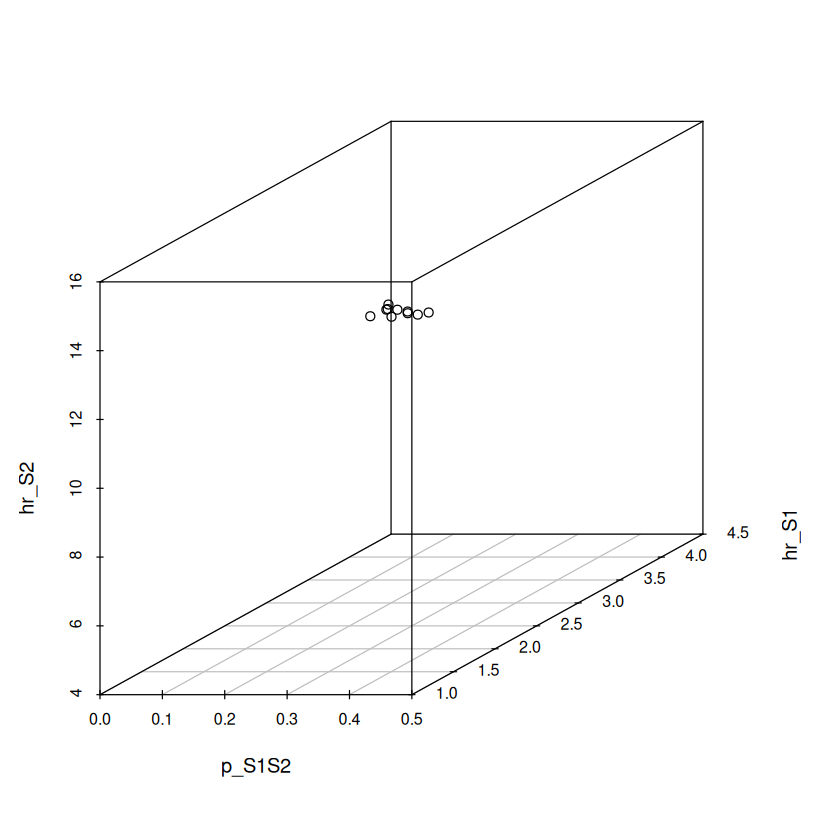

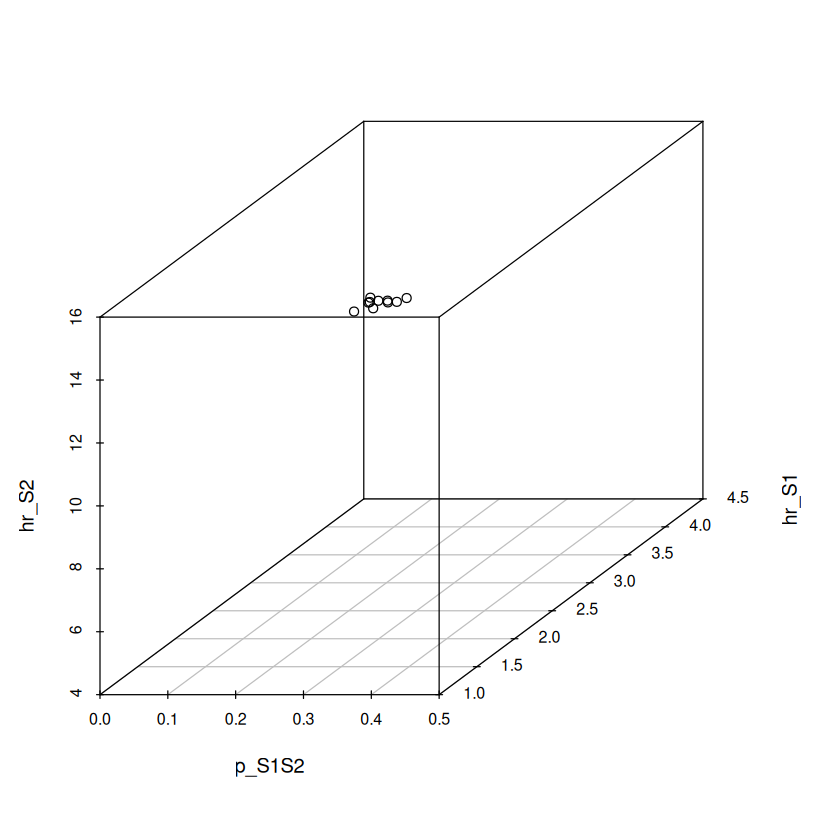

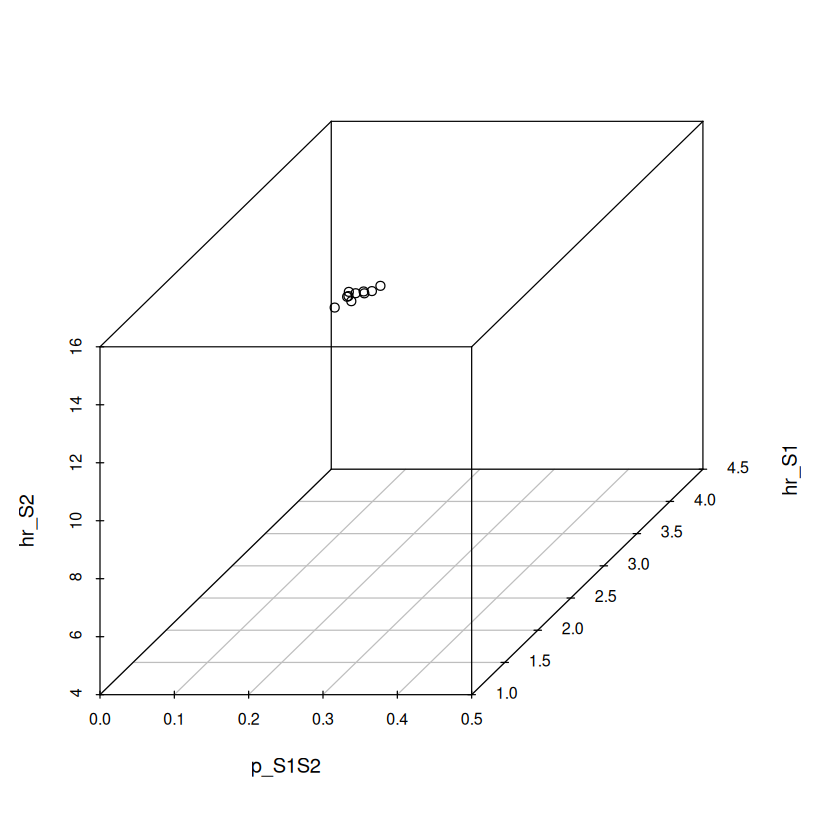

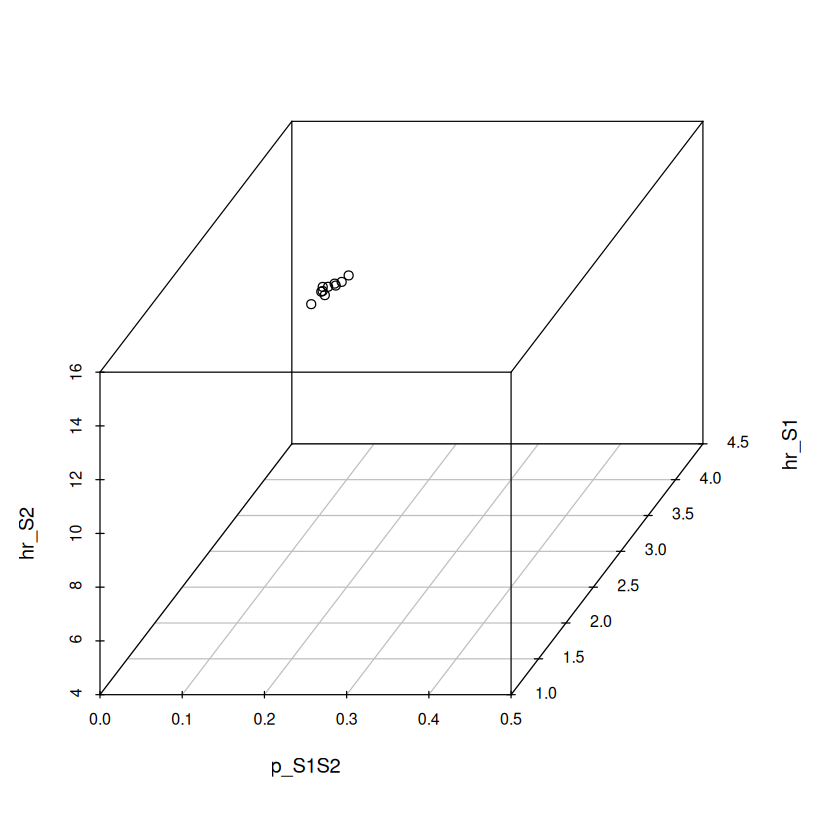

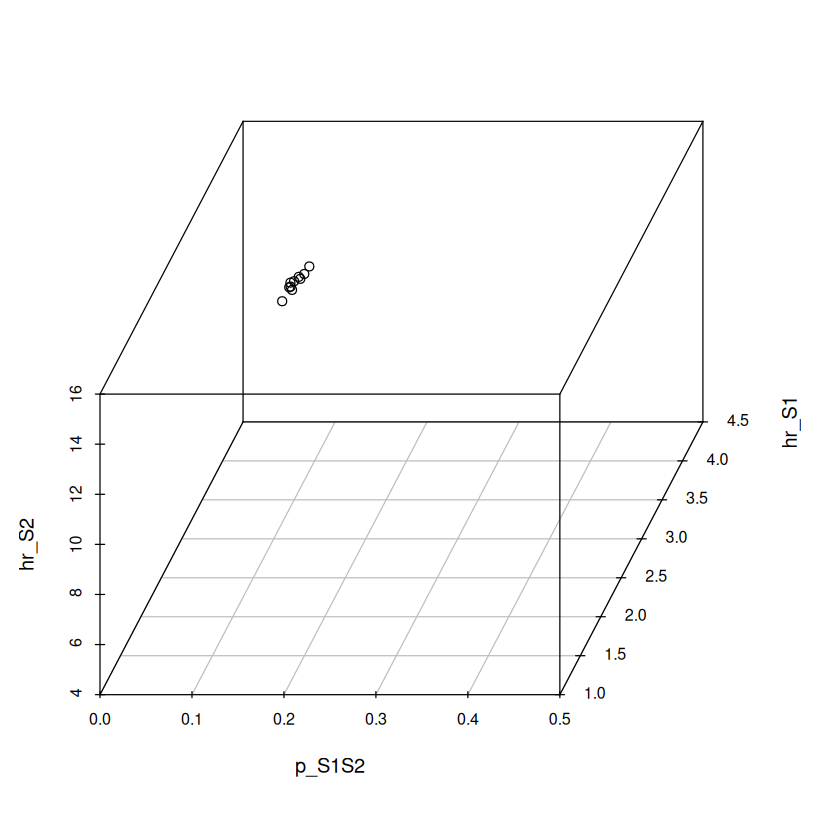

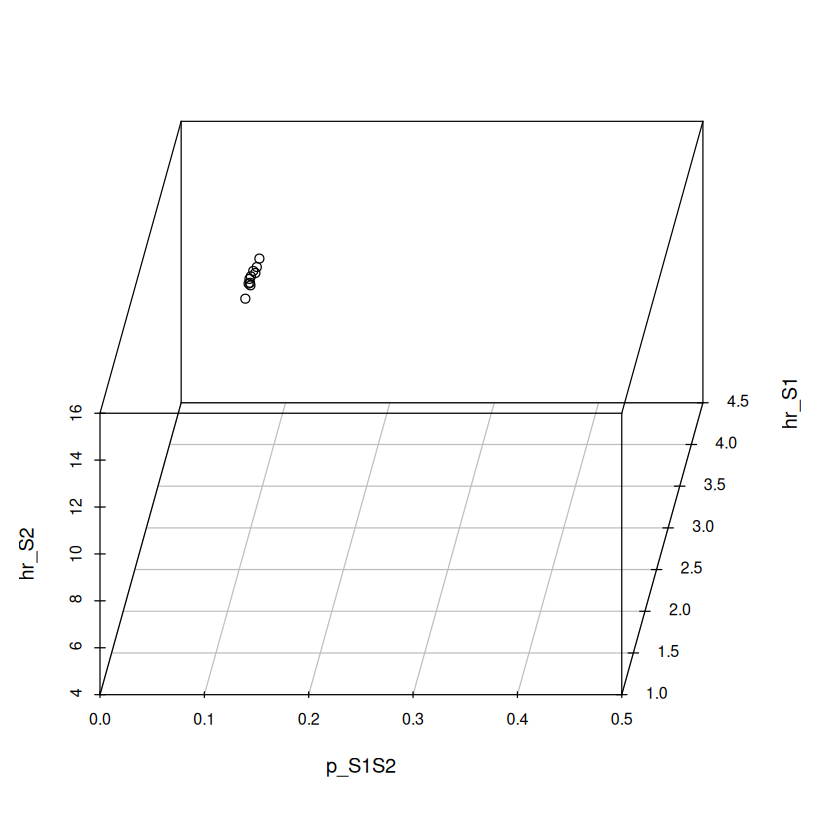

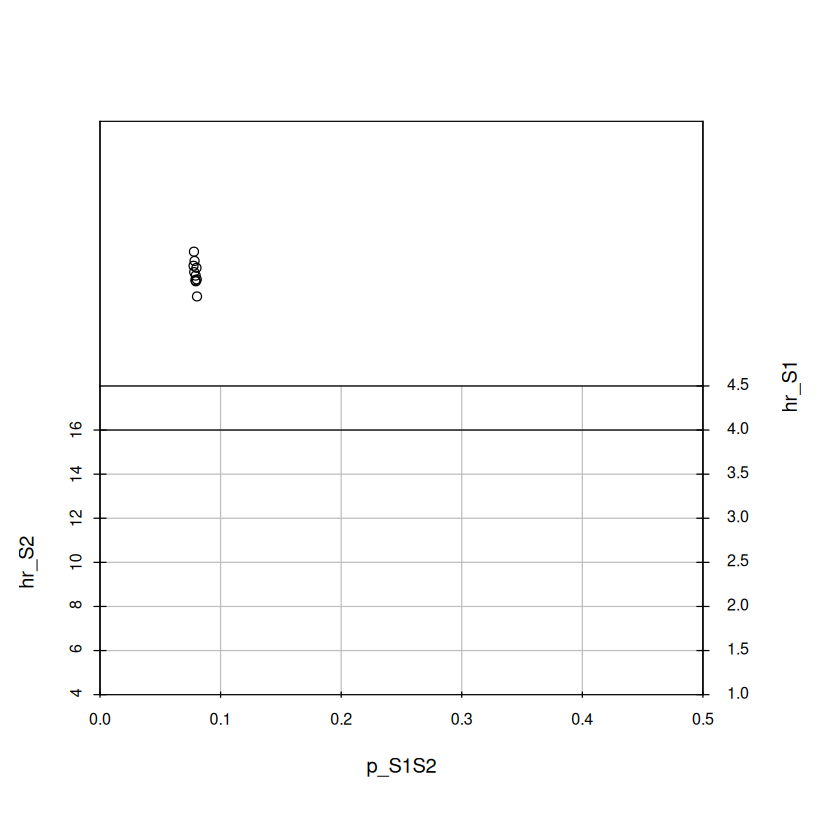

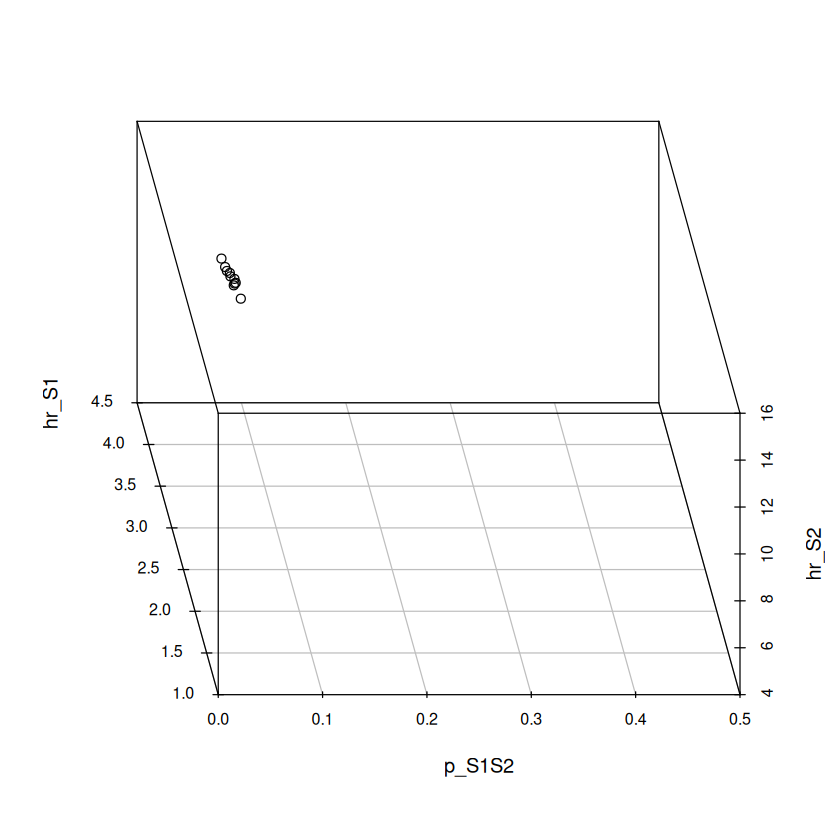

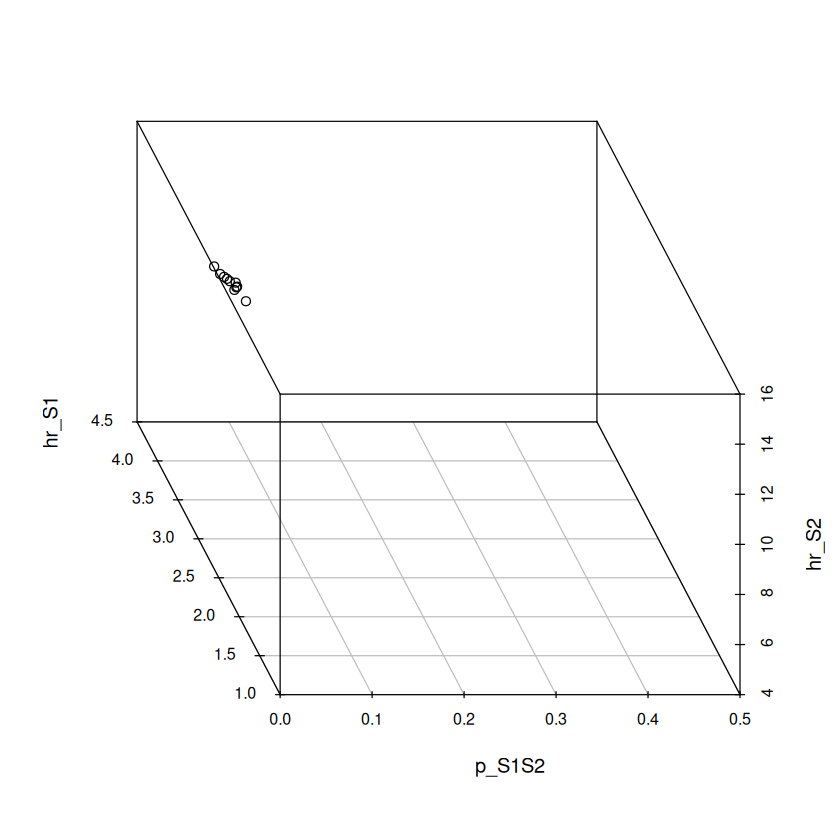

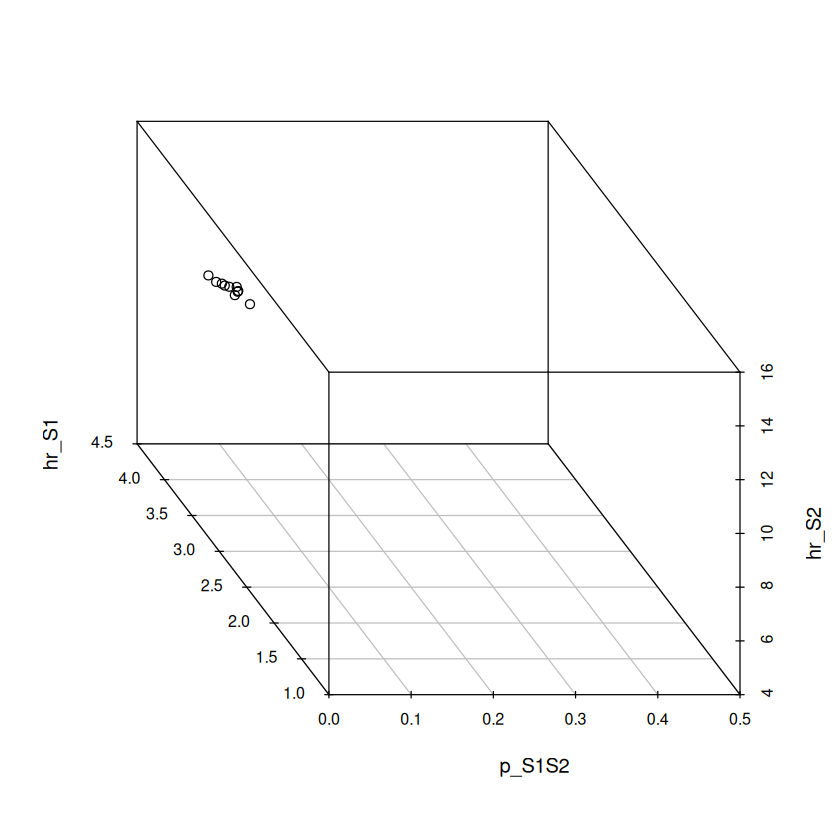

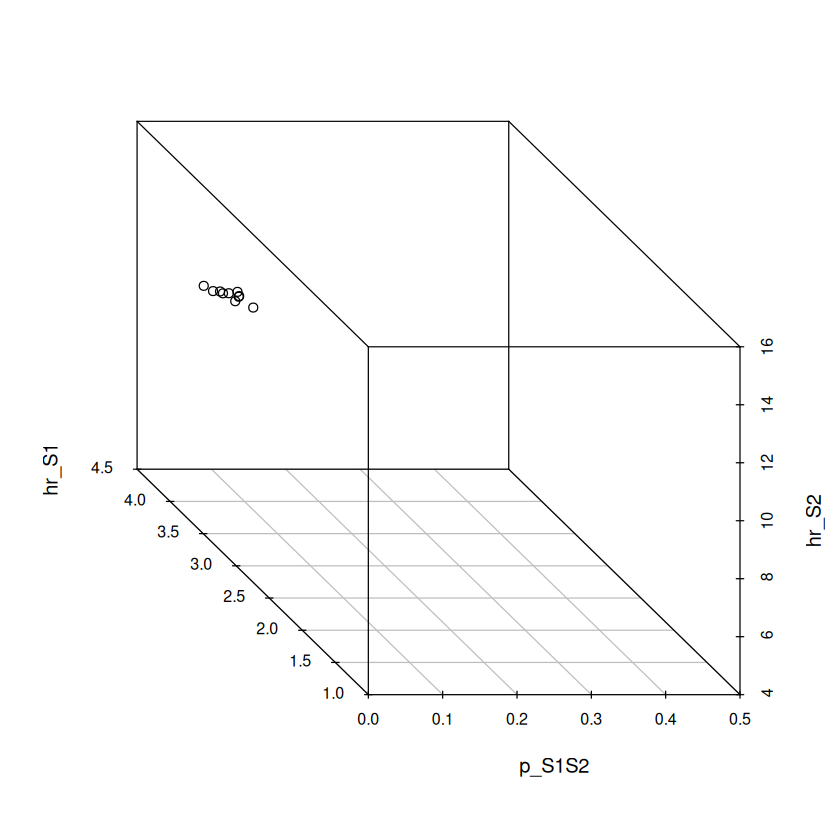

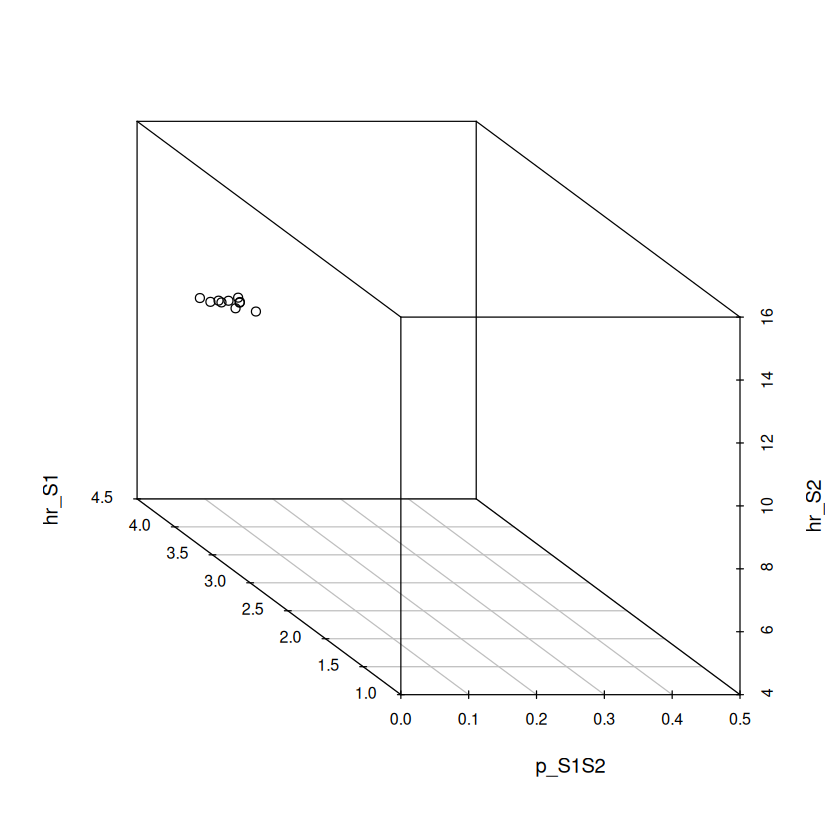

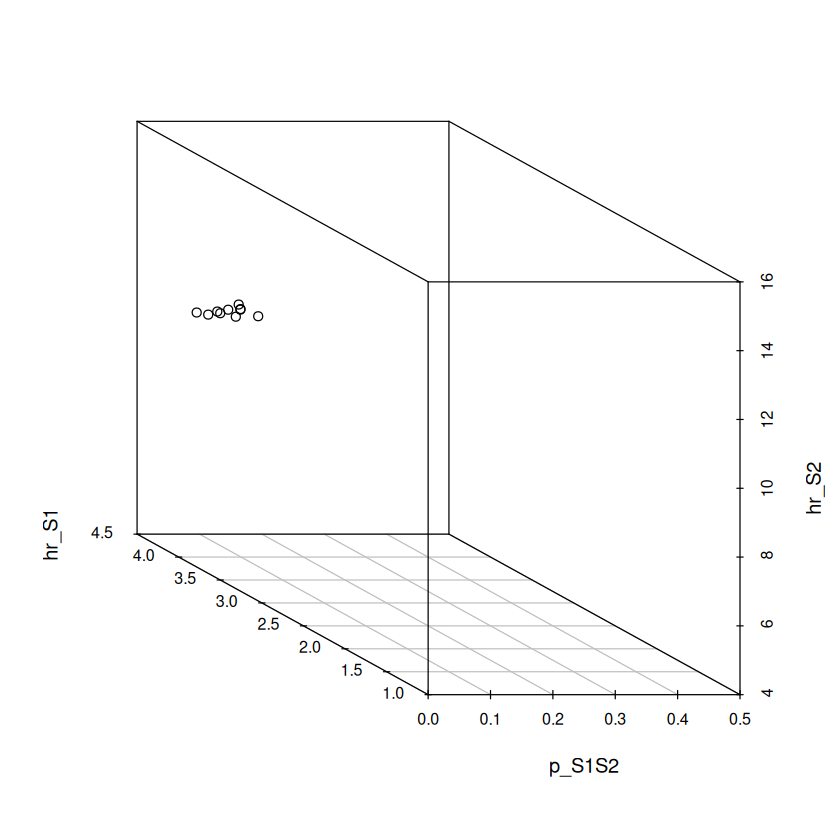

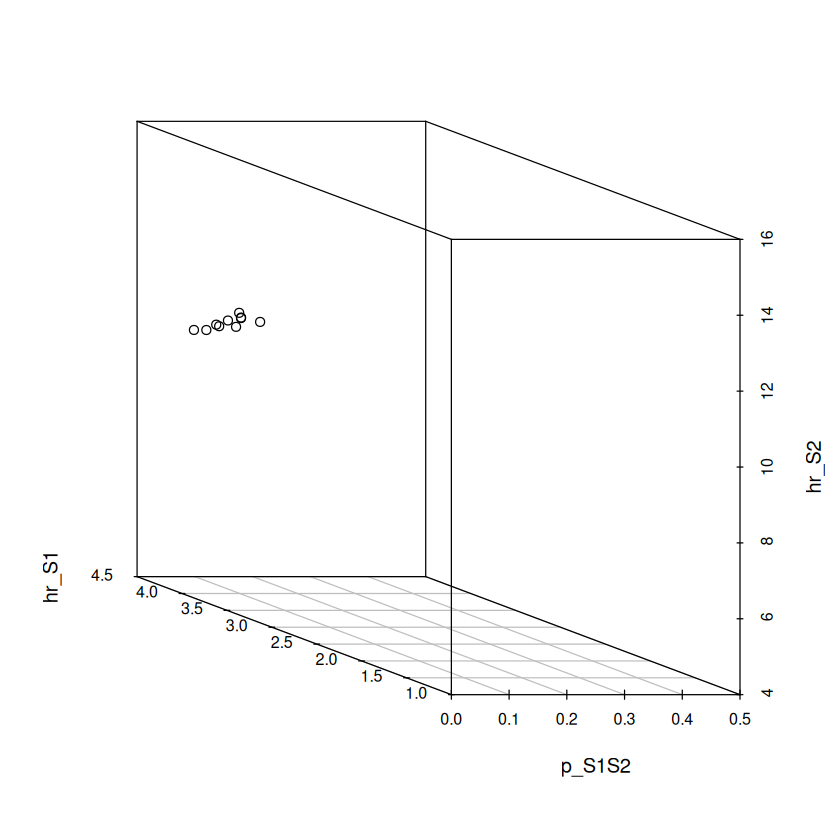

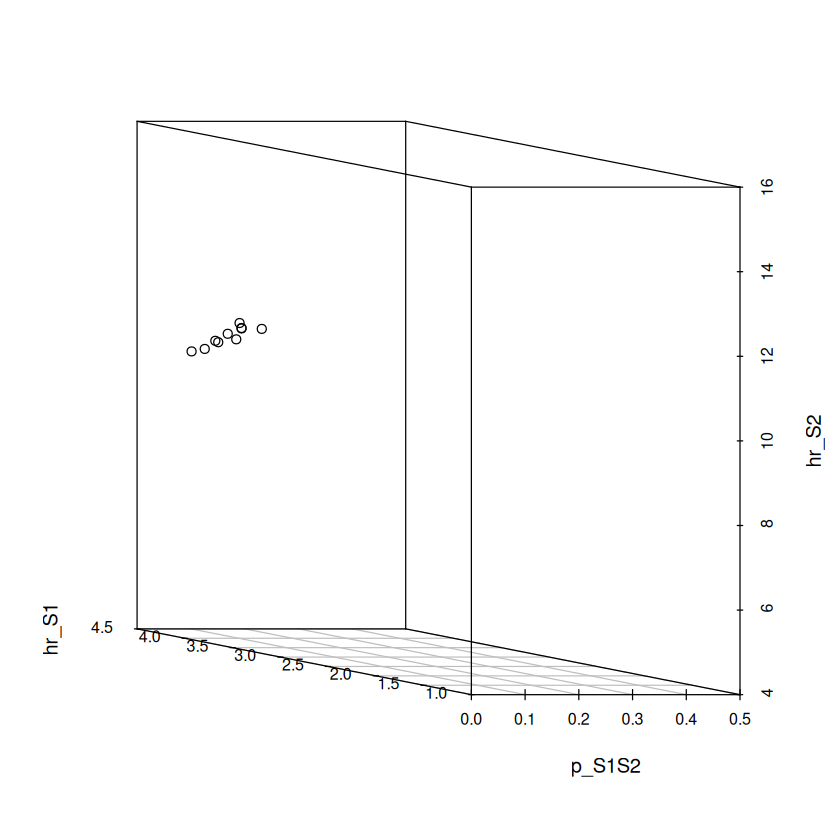

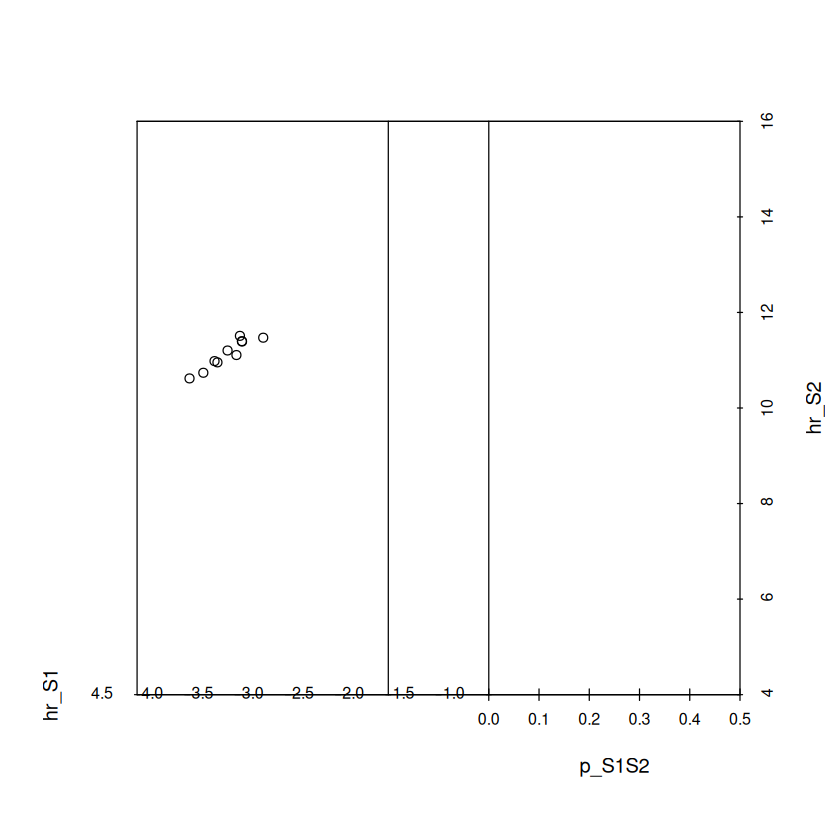

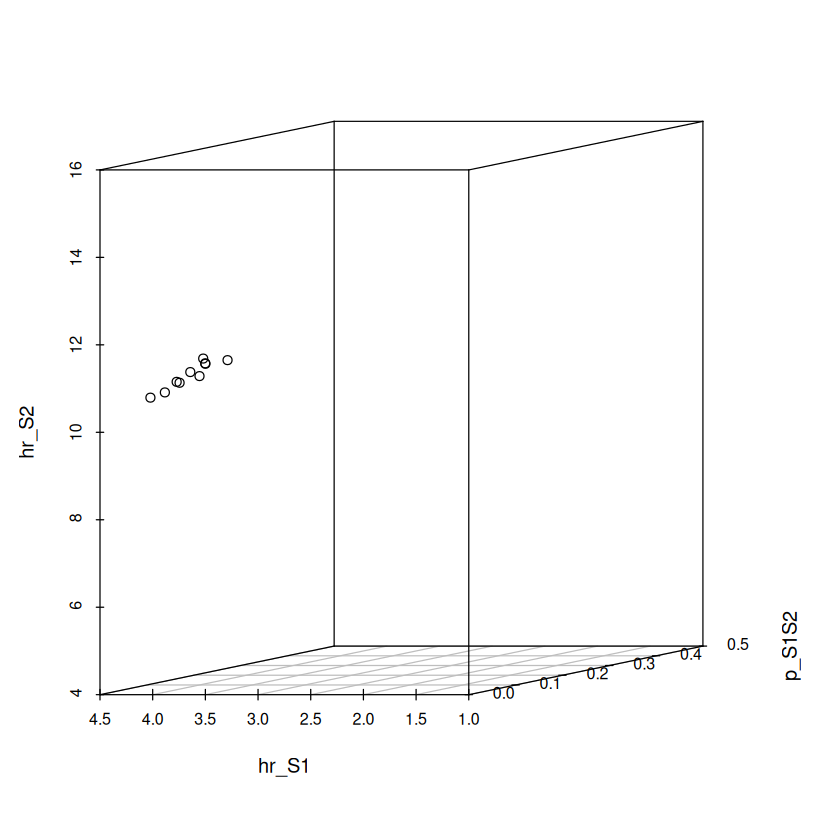

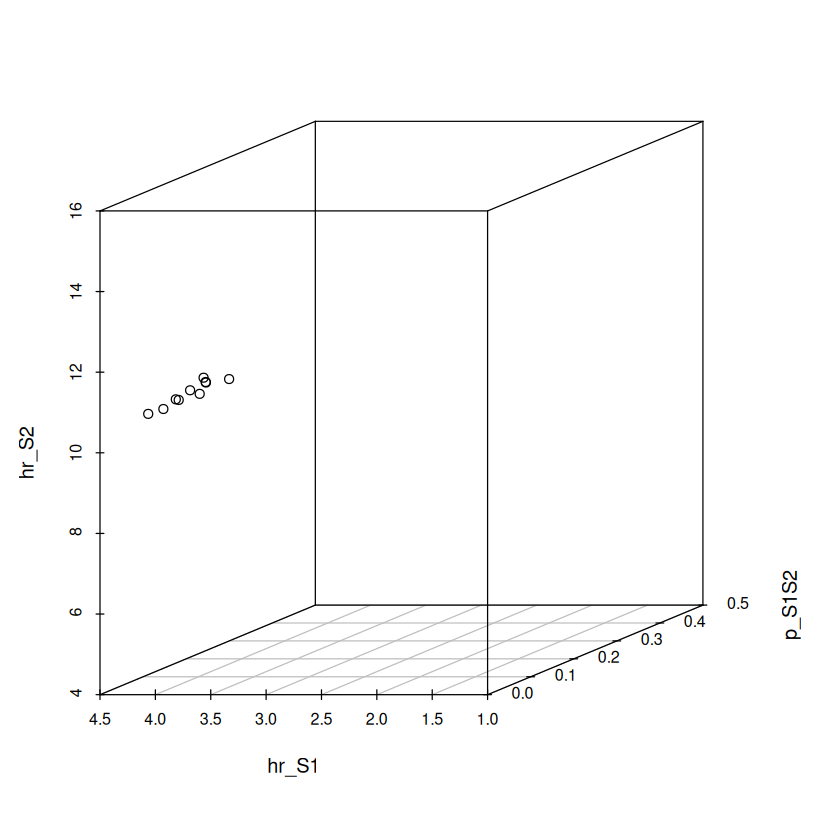

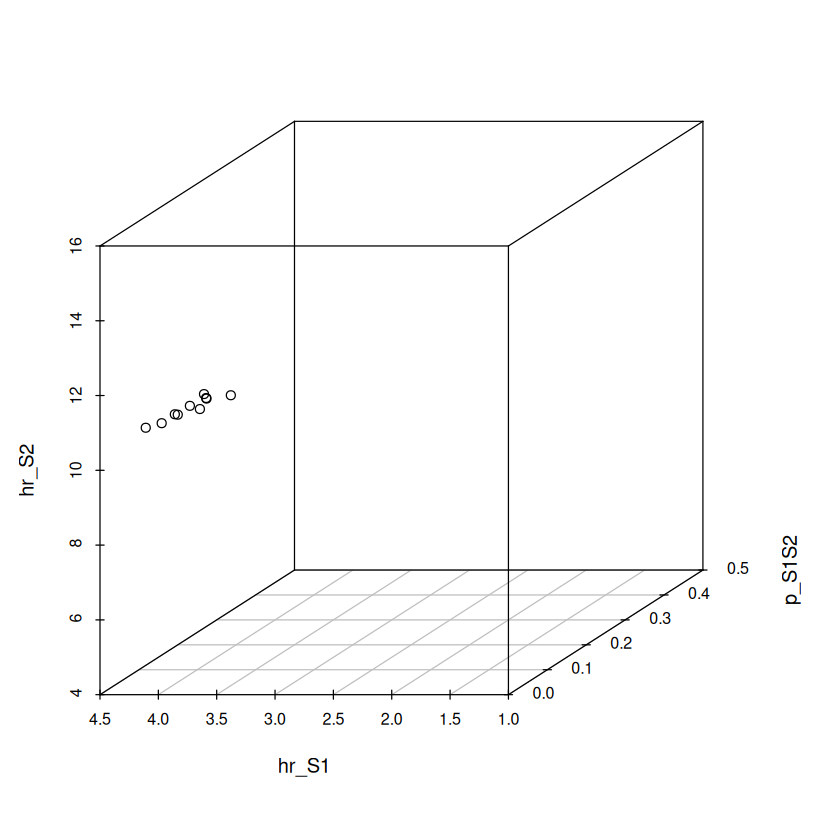

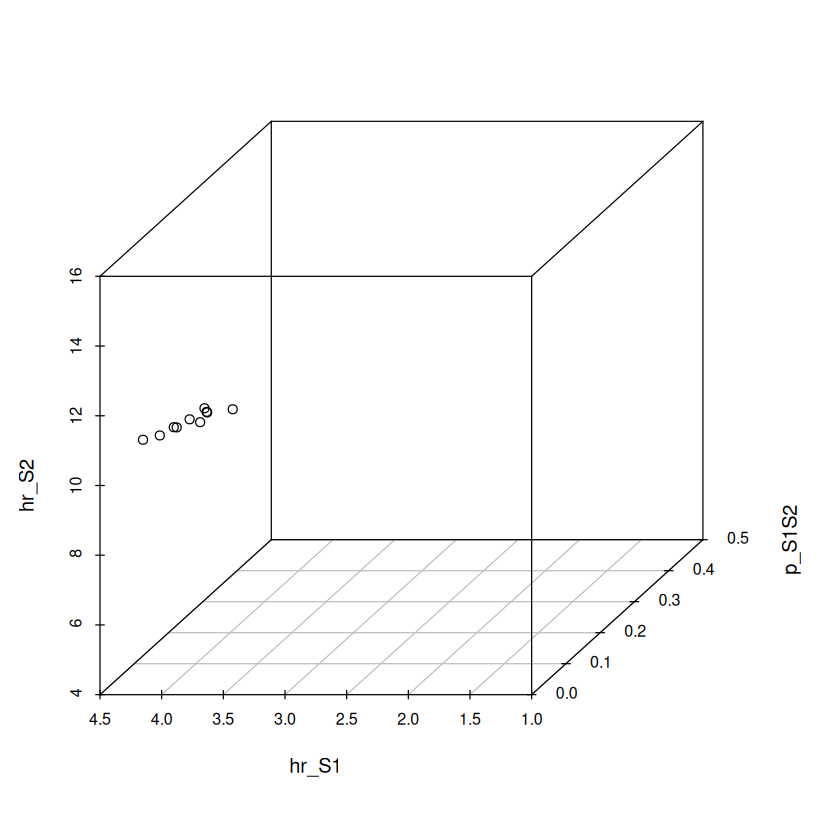

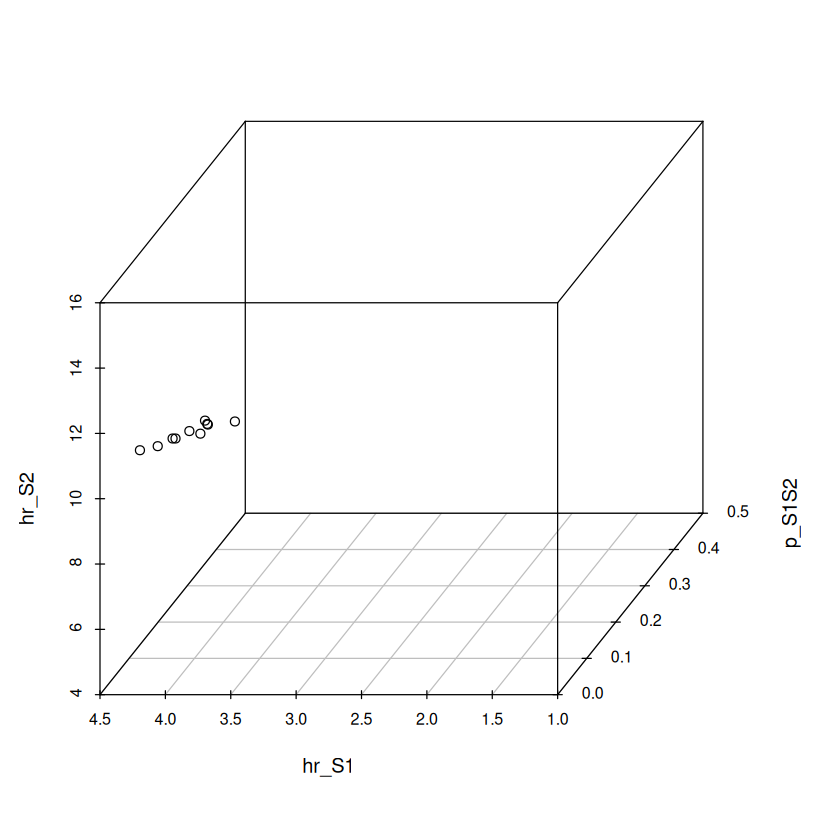

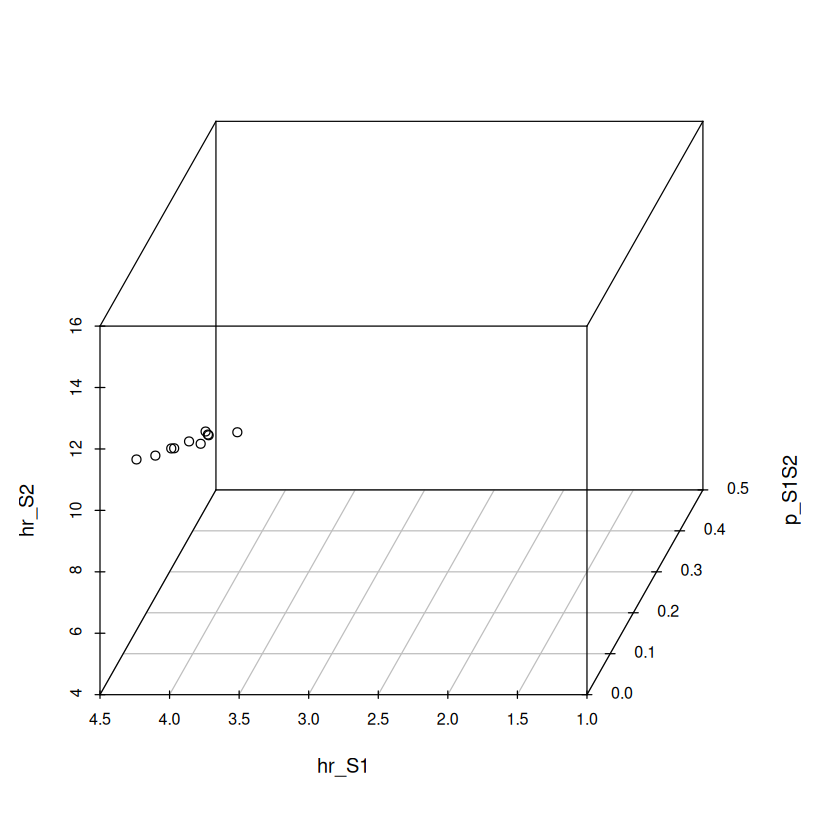

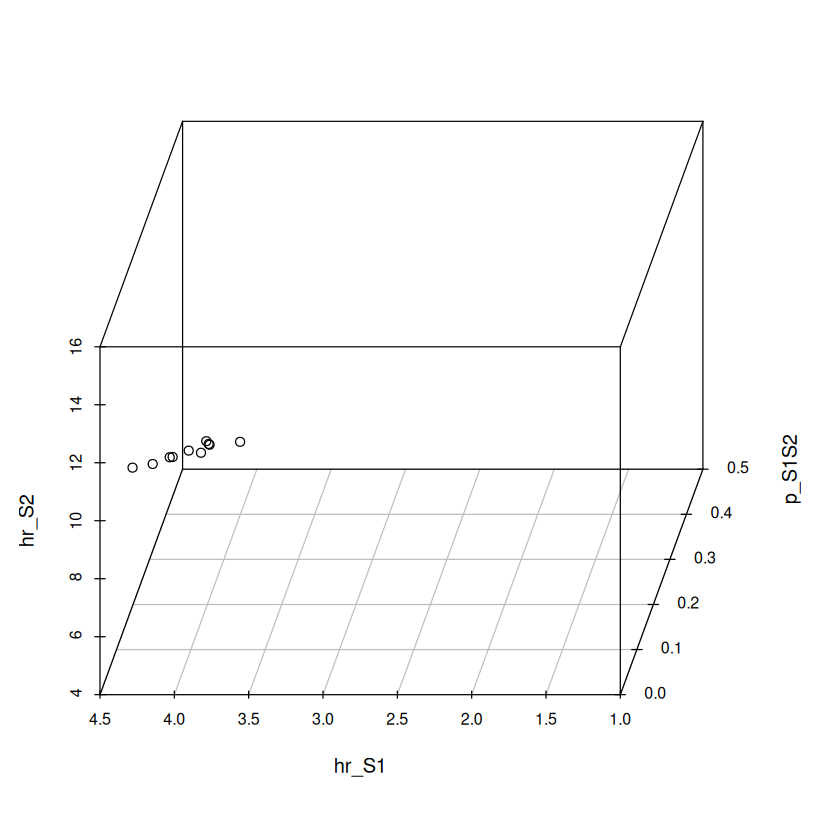

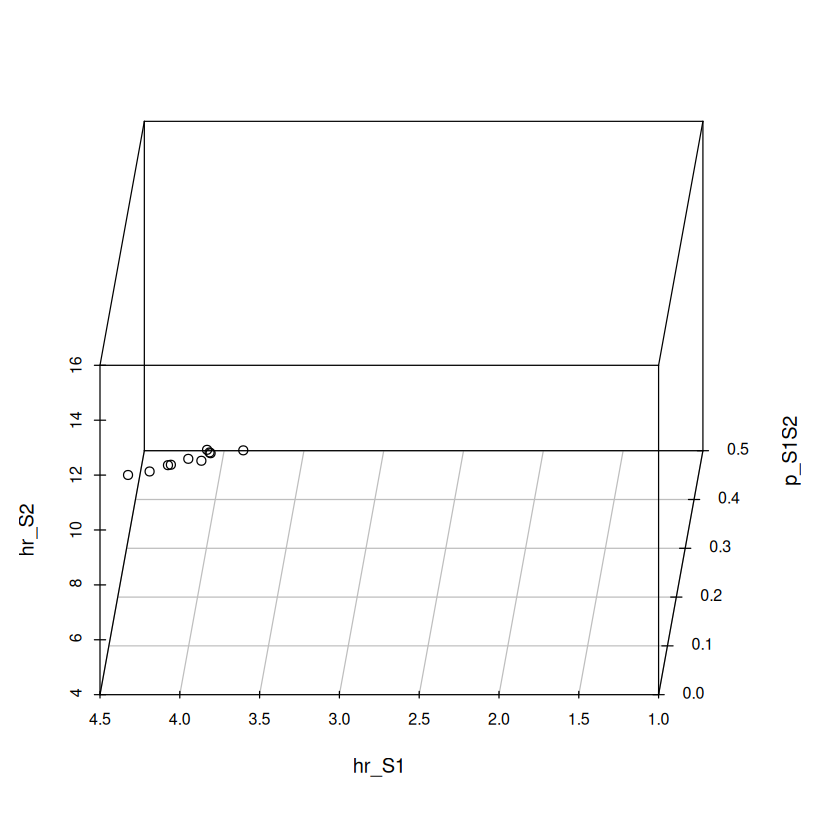

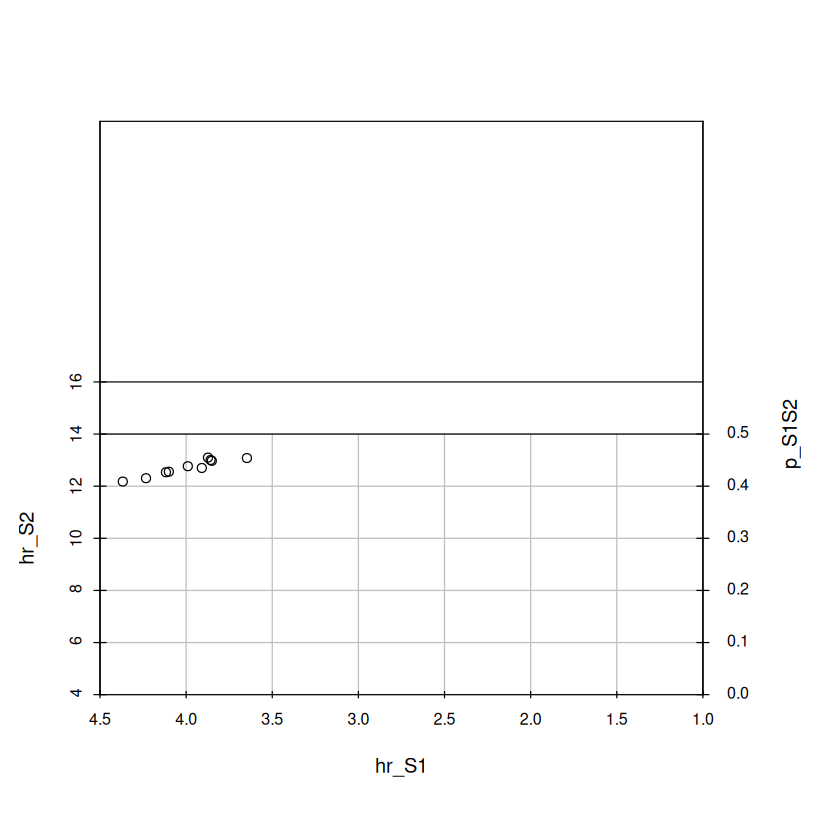

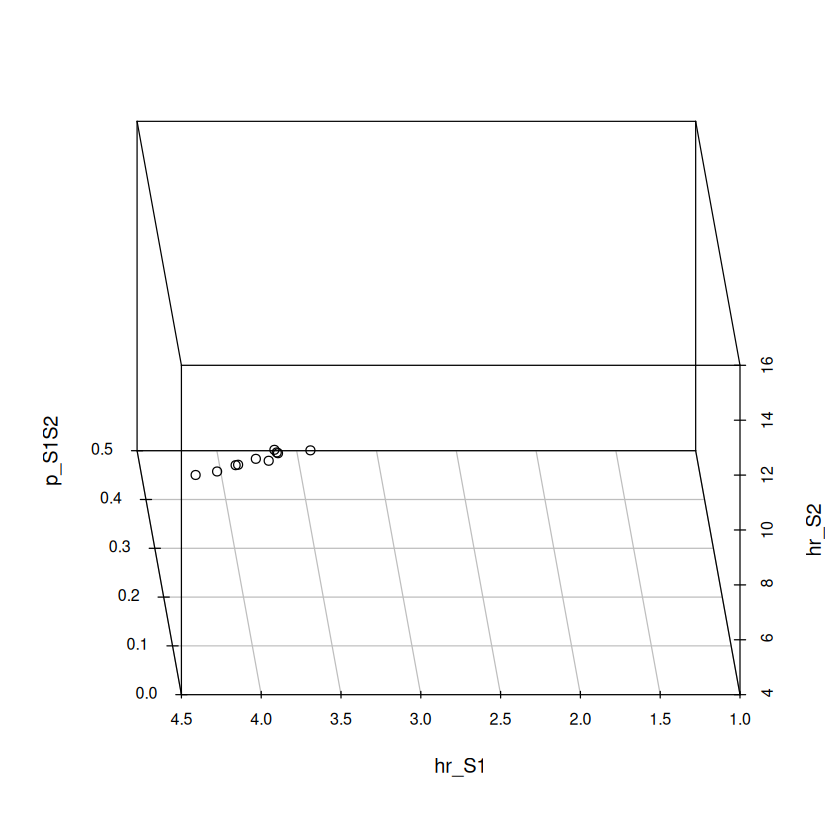

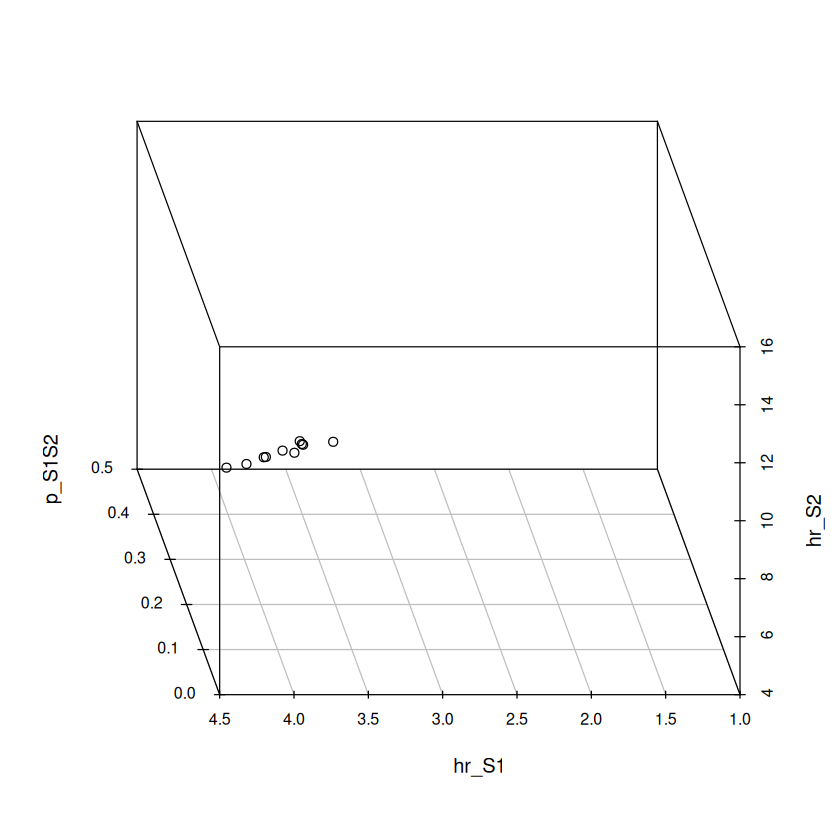

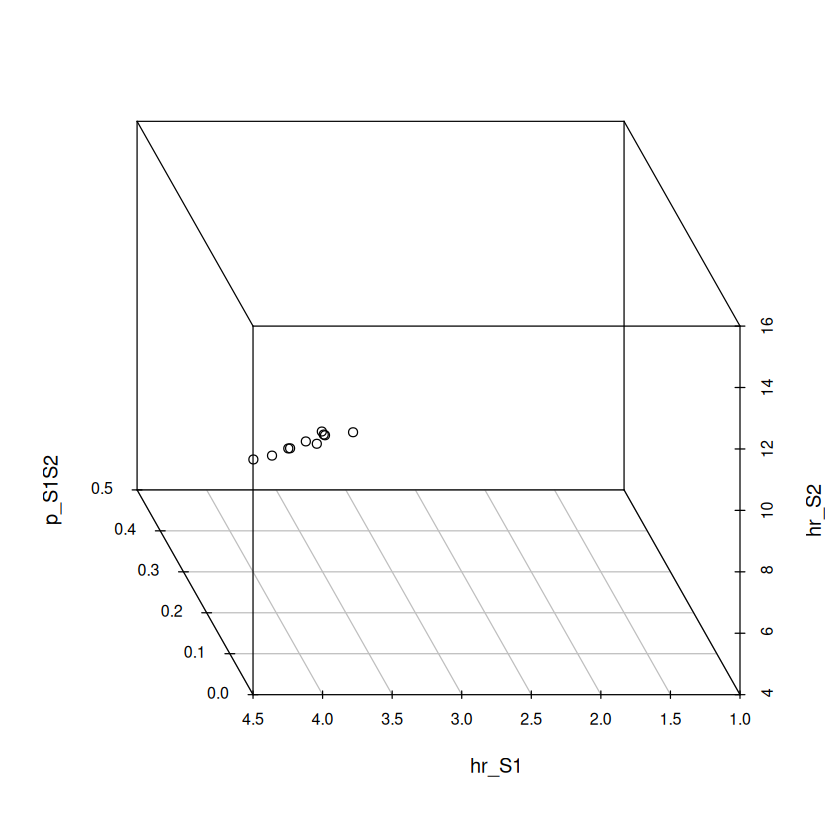

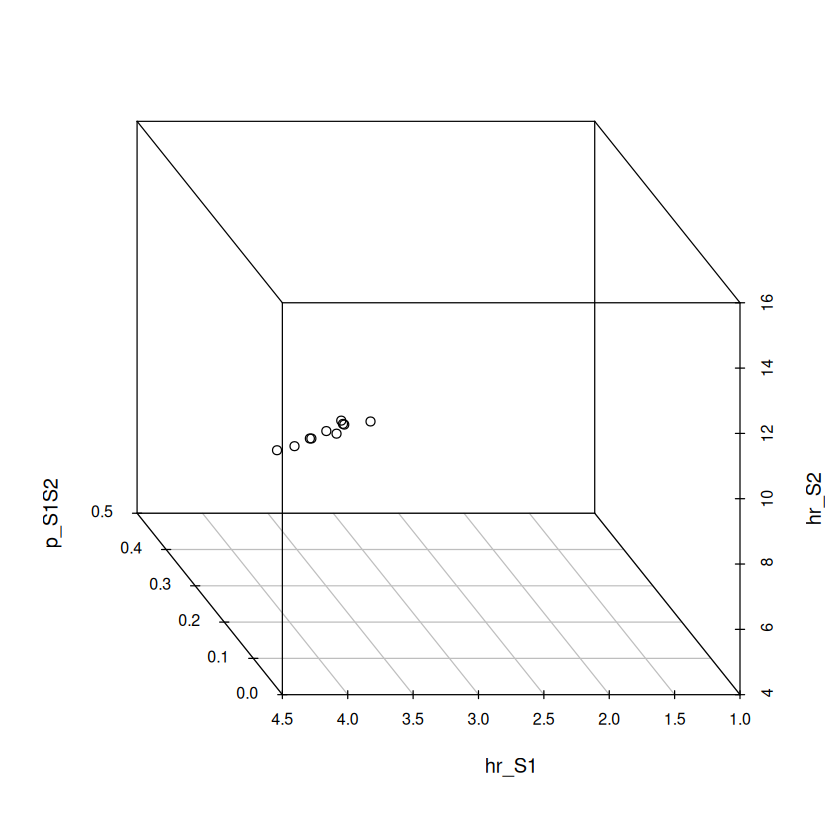

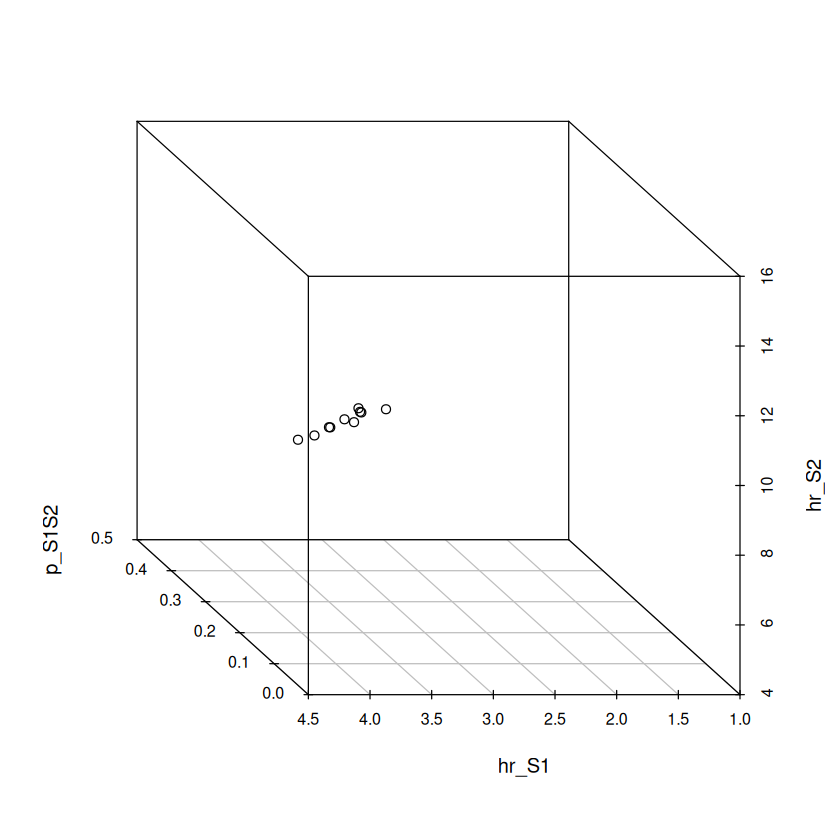

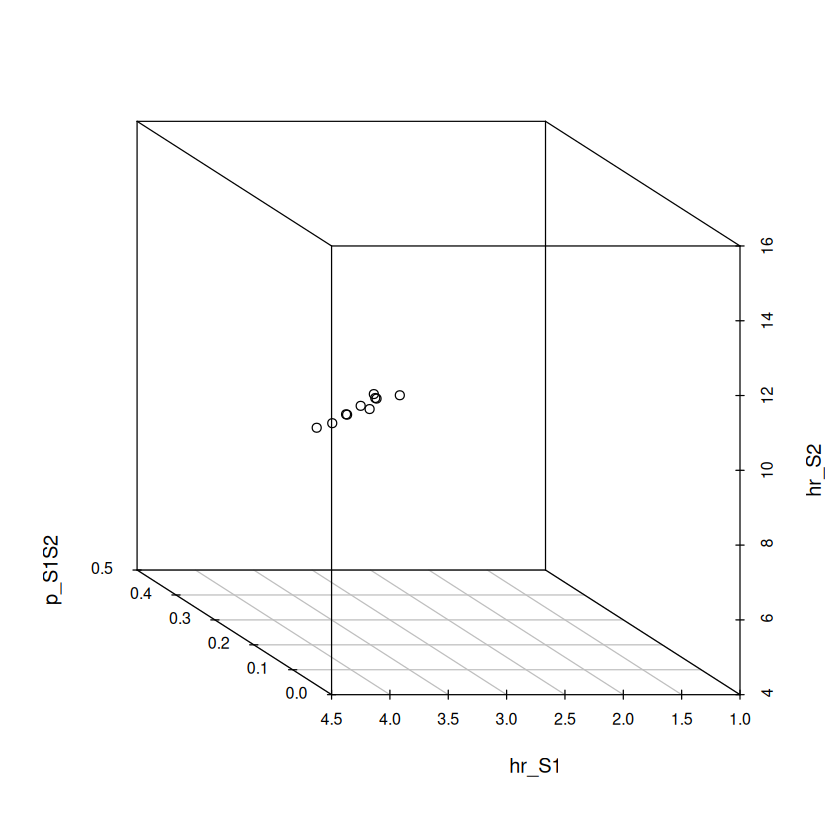

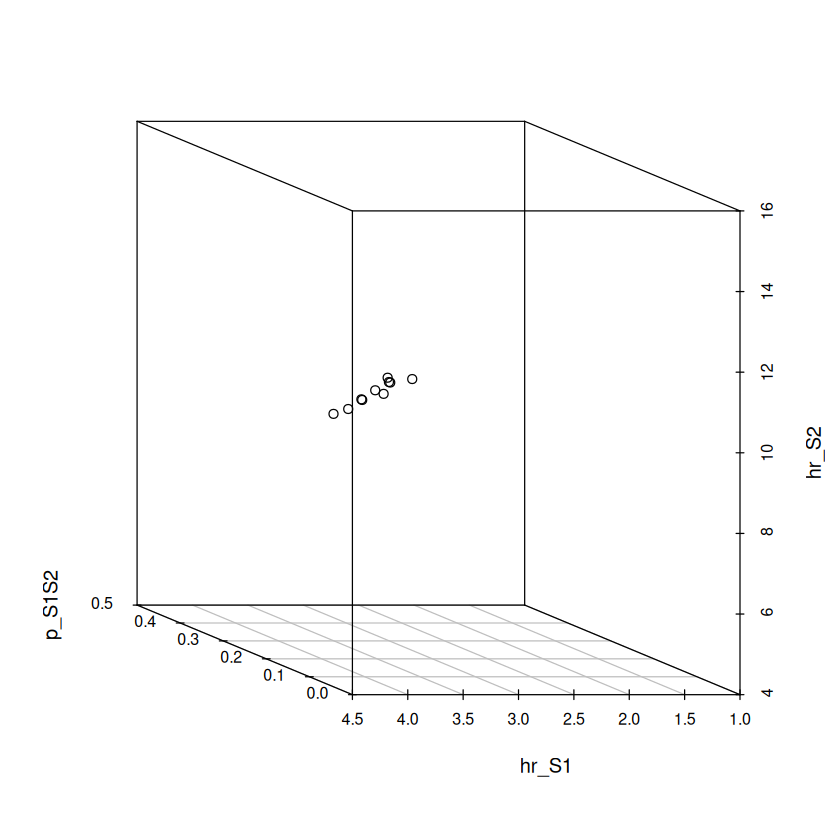

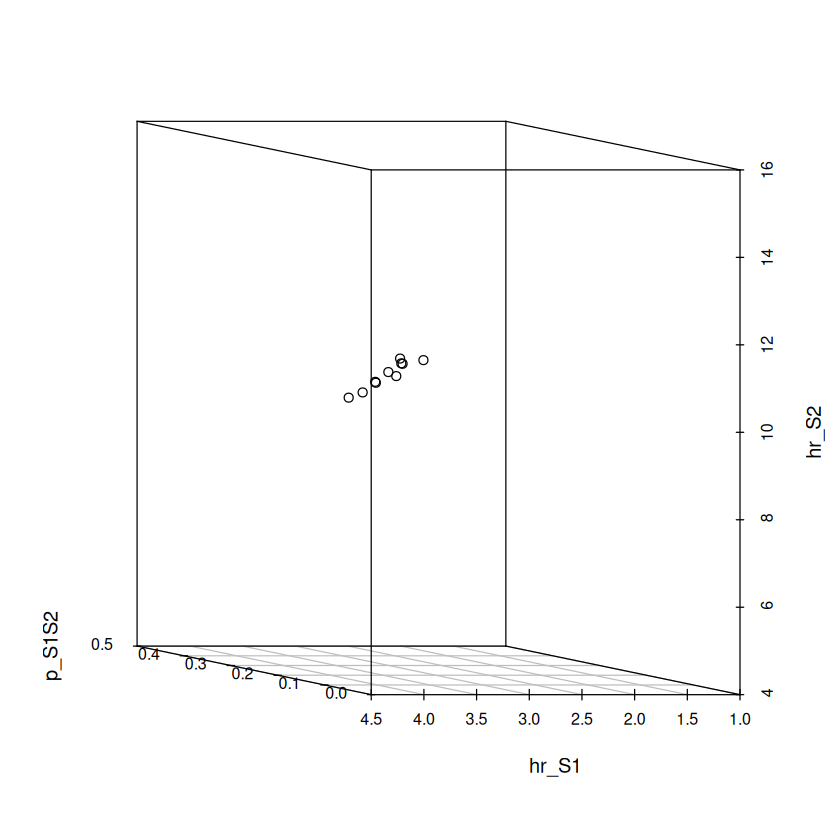

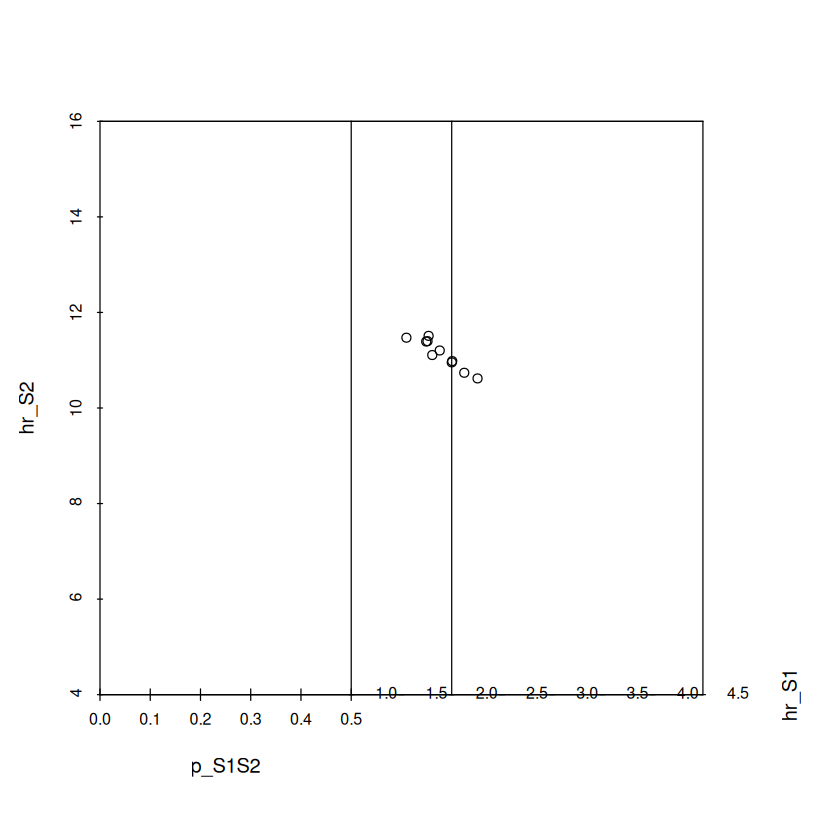

In [114]:
### 08.02 Visualize best-fitting parameter sets in 3D  -------------------------
for(ang in seq(0,360,10)) {
    scatterplot3d(x = m_calib_res[1:10, 1],
                  y = m_calib_res[1:10, 2],
                  z = m_calib_res[1:10, 3],
                  xlim = c(lb[1], ub[1]), 
                  ylim = c(lb[2], ub[2]), 
                  zlim = c(lb[3], ub[3]),
                  xlab = v_param_names[1], 
                  ylab = v_param_names[2], 
                  zlab = v_param_names[3],
                  angle = ang)
}

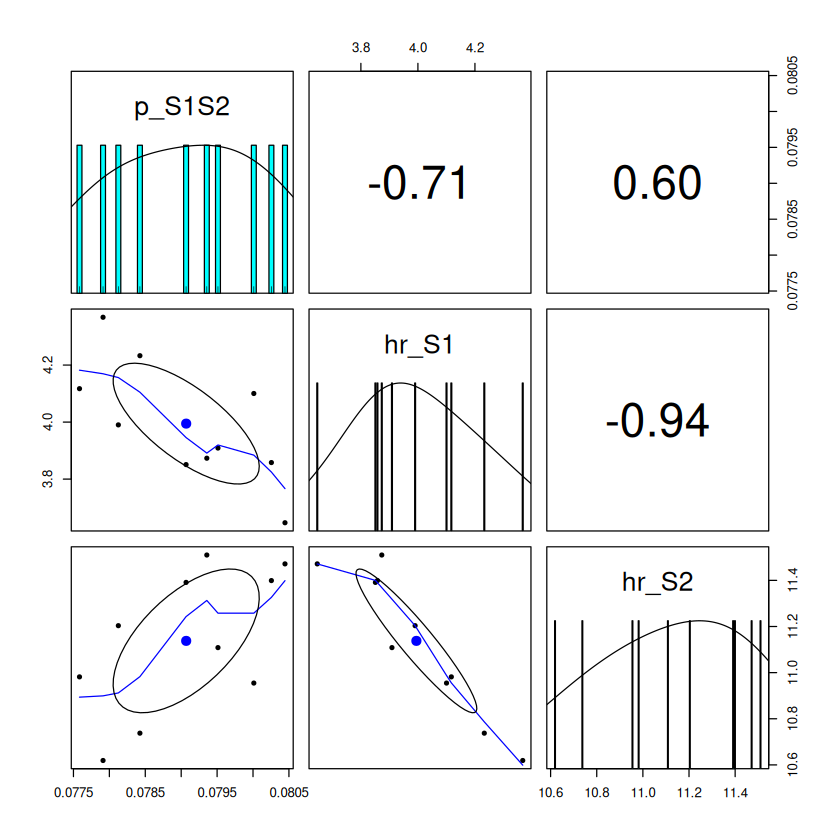

In [113]:
### 08.03 Pairwise plots of top parameter sets  --------------------------------
pairs.panels(m_calib_res[1:10, v_param_names])

### 08.04 Compare model predictions to targets  --------------------------------
# Compute output from best parameter set
v_out_best <- run_sick_sicker_markov(m_calib_res[1, ])

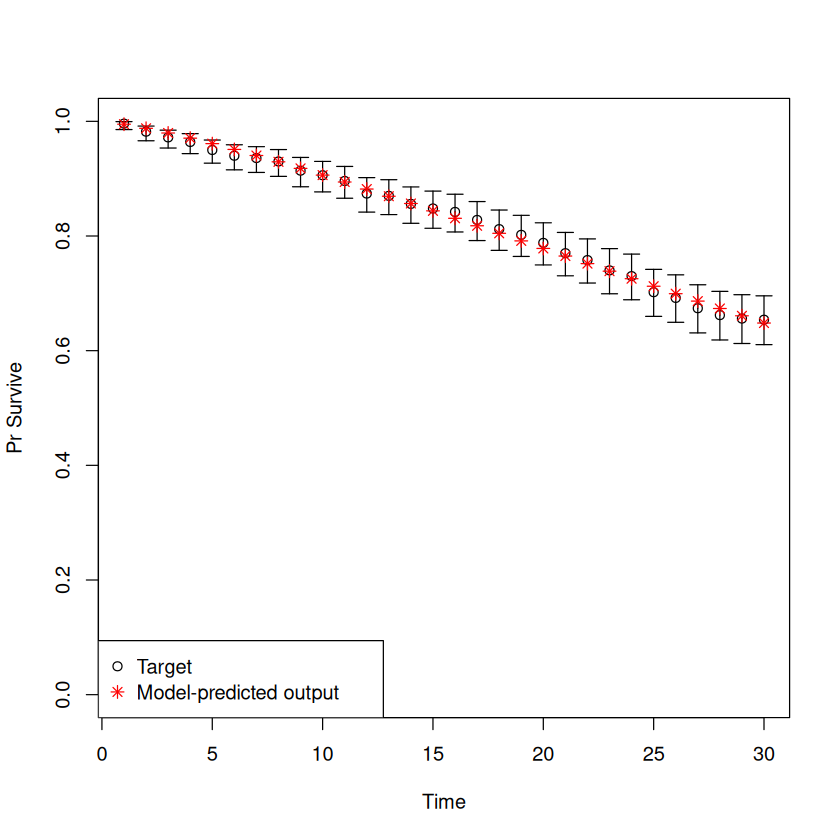

In [101]:
# Plot: TARGET 1: Survival
plotrix::plotCI(x = lst_targets$Surv$time, 
                y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", 
                ylab = "Pr Survive")

points(x = lst_targets$Surv$time, 
       y = v_out_best$Surv, 
       pch = 8, col = "red")

legend("bottomleft", 
       legend = c("Target", "Model-predicted output"),
       col = c("black", "red"), 
       pch = c(1, 8))

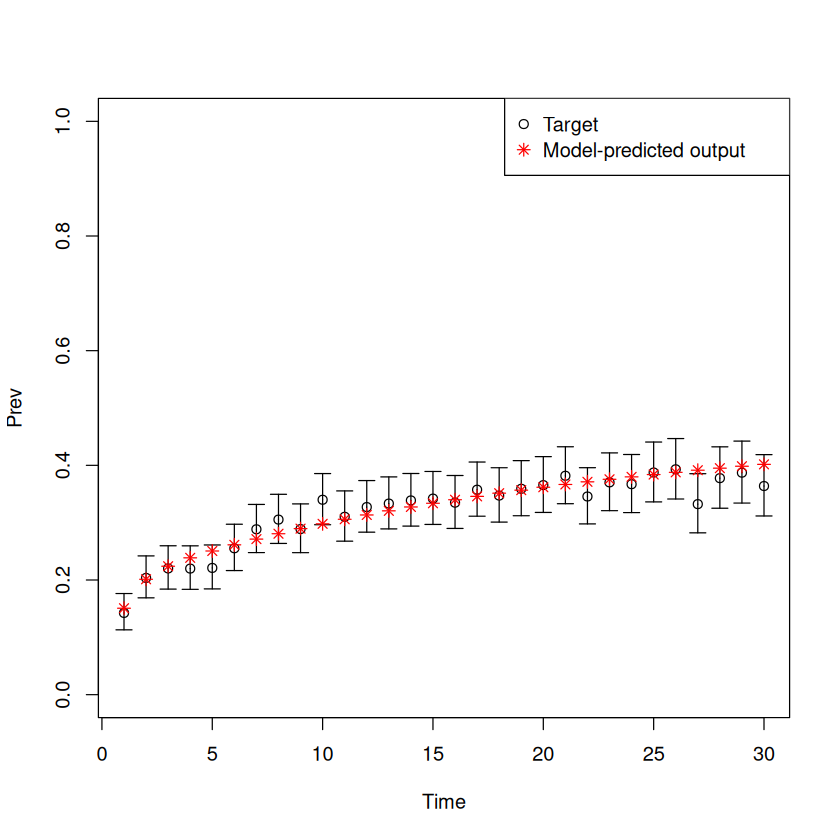

In [102]:
# Plot: TARGET 2: Prevalence
plotrix::plotCI(x = lst_targets$Prev$time, 
                y = lst_targets$Prev$value,
                ui = lst_targets$Prev$ub,
                li = lst_targets$Prev$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "Prev")

points(x = lst_targets$Prev$time,
       y = v_out_best$Prev,
       pch = 8, col = "red")

legend("topright",
       legend = c("Target", "Model-predicted output"),
       col = c("black", "red"), 
       pch = c(1, 8))

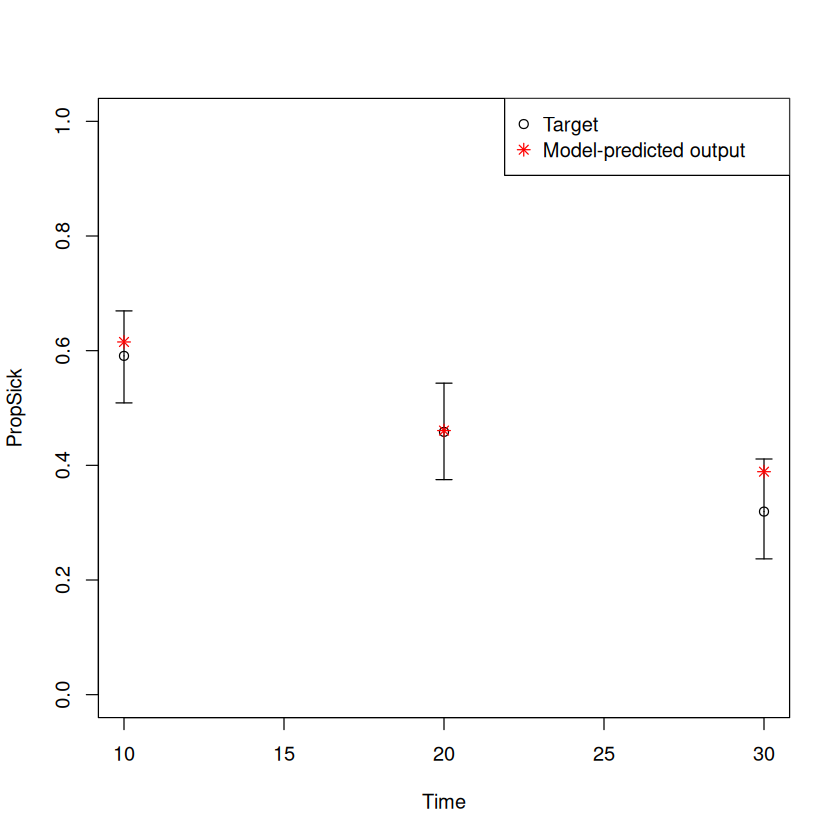

In [103]:
# Plot: TARGET 3: PropSick
plotrix::plotCI(x = lst_targets$PropSick$time, 
                y = lst_targets$PropSick$value,
                ui = lst_targets$PropSick$ub,
                li = lst_targets$PropSick$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "PropSick")

points(x = lst_targets$PropSick$time,
       y = v_out_best$PropSick,
       pch = 8, col = "red")

legend("topright",
       legend = c("Target", "Model-predicted output"),
       col = c("black", "red"), 
       pch = c(1, 8))

,p_S1S2,hr_S1,hr_S2
p_S1S2,-136380.02760,-616.737259,29.084449
hr_S1,-616.73726,-11.574639,-4.926401
hr_S2,29.08445,-4.926401,-3.481948


[1] -4.183004e-01 -1.184291e+01 -1.363828e+05

[1] "Hessian IS Positive Definite"
[1] "No additional adjustment to COV matrix"


,p_S1S2,hr_S1,hr_S2
p_S1S2,1.0000000,-0.8309383,0.7700135
hr_S1,-0.8309383,1.0000000,-0.9152971
hr_S2,0.7700135,-0.9152971,1.0000000


p_S1S2       hr_S1       hr_S2 
0.004871384 0.837618427 1.331707268

,LB,UB
p_S1S2,0.06996413,0.08905995
hr_S1,2.26723057,5.55069480
hr_S2,8.49833266,13.71862515


`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


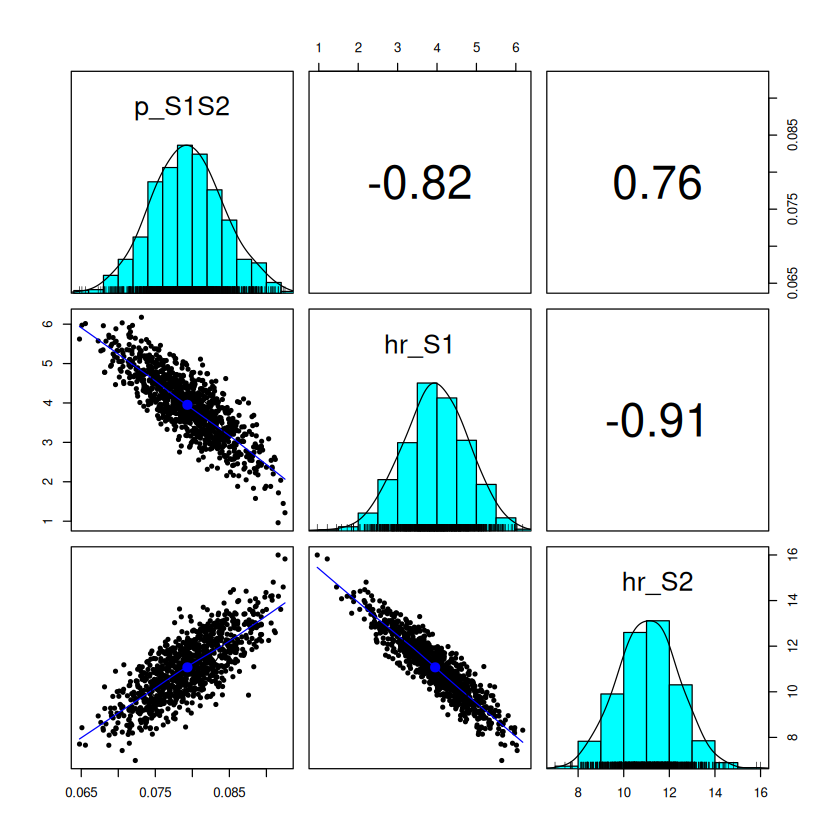

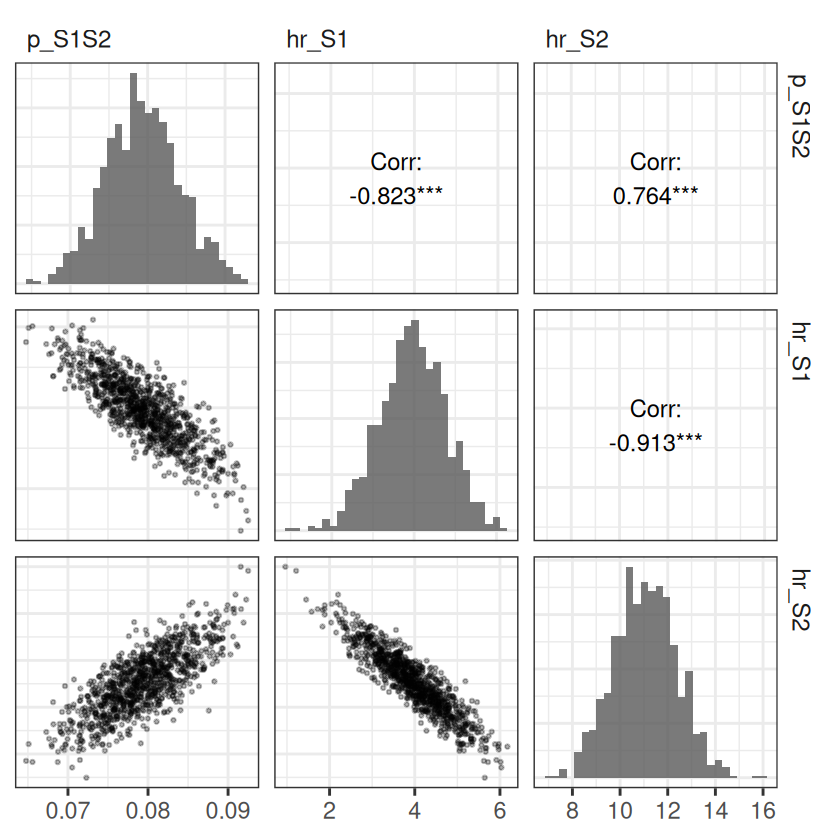

In [104]:
# ******************************************************************************
# 09 Uncertainty quantification ------------------------------------------------
# ******************************************************************************

### 09.01 Extract Hessian matrix  ----------------------------------------------
m_hess <- l_fit_nm[[id_best_set]]$hessian
m_hess
# check if hessian is negative definite
eigen(m_hess)$values

### 09.02 Covariance matrix  ---------------------------------------------------
# Check if HESSIAN is Positive Definite; If not, make covariance 
# Positive Definite
# Is Positive Definite?
if (!is.positive.definite(-m_hess)) {
  print("Hessian is NOT Positive Definite")
  m_cov <- solve(-m_hess)
  print("Compute nearest positive definite matrix for COV matrix using `nearPD` function")
  m_cov <- Matrix::nearPD(m_cov)$mat
} else{
  print("Hessian IS Positive Definite")
  print("No additional adjustment to COV matrix")
  m_cov <- solve(-m_hess)
}

### 09.03 Correlation matrix  ---------------------------------------------------
m_cor <- cov2cor(m_cov)
m_cor

### 09.04 Calculate standard errors  -------------------------------------------
m_se <- sqrt(diag(m_cov))
m_se

### 09.05 Calculate 95% confidence interval  -----------------------------------
m_confint <- cbind(v_param_best - 1.96*m_se,
                   v_param_best + 1.96*m_se)
colnames(m_confint) <- c("LB", "UB")
m_confint

### 09.06 Sample from multivariate normal distribution  ------------------------
n_samp <- 1000
m_param_best_sample <- rmvnorm(n = n_samp, 
                               mean = v_param_best, 
                               sigma = m_cov)
colnames(m_param_best_sample) <- v_param_names

### 09.07 Visualize parameter samples  -----------------------------------------
pairs.panels(m_param_best_sample)

### 09.08 Advanced visualization: pairwise correlations  -----------------------
gg_nm_pairs_corr <- GGally::ggpairs(
  data.frame(m_param_best_sample),
  upper = list(continuous = wrap("cor",
                                 color = "black",
                                 size = 5)),
  diag = list(continuous = wrap("barDiag",
                                alpha = 0.8)),
  lower = list(continuous = wrap("points", 
                                 alpha = 0.3,
                                 size = 0.7)),
  columnLabels = v_param_names
) +
  theme_bw(base_size = 18) +
  theme(axis.title.x = element_blank(),
        axis.text.x  = element_text(size = 14),
        axis.title.y = element_blank(),
        axis.text.y  = element_blank(),
        axis.ticks.y = element_blank(),
        strip.background = element_rect(fill = "white",
                                        color = "white"),
        strip.text = element_text(hjust = 0))
gg_nm_pairs_corr